# Sharpe vs Return Weight Sweep (DRL vs ES)

This notebook:
- Trains **the same MLP architecture** with:
  - DRL (gradient-based) via `train_drl`
  - ES (mirrored evolution strategies) via `train_es`
- Sweeps different `(w_sharpe, w_return)` combinations to compare:
  - Convergence (train/test loss curves)
  - Performance (wealth curves)
  - Allocation policy (weights over time)



In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import jax
import jax.numpy as jnp
from jax import random

from v1_MLP import MLP
from v1_DRL import TrainConfig, train_drl, evaluate_policy_with_weights
from v1_evolutionary_strategy import ESConfig, train_es

from visualizations import (
    plot_loss_curve,
    plot_episode_performance_split,
    plot_allocation_over_time,
)

import matplotlib.pyplot as plt


## 1) Load data (same as `v1_attempt.ipynb`)


In [2]:
DATA_DIR = Path("data")  # adjust if needed

prices_adj = pd.read_csv(DATA_DIR / "etf_prices_adj.csv", index_col=0, parse_dates=True)
log_ret = pd.read_csv(DATA_DIR / "etf_returns_log.csv", index_col=0, parse_dates=True)
simple_ret = pd.read_csv(DATA_DIR / "etf_returns_simple.csv", index_col=0, parse_dates=True)

prices_adj = prices_adj.sort_index()
log_ret = log_ret.sort_index()
log_ret = log_ret.reindex(prices_adj.index).ffill().dropna(how="all")

simple_ret = simple_ret.sort_index()
simple_ret = simple_ret.reindex(prices_adj.index).ffill().dropna(how="all")

print("prices_adj:", prices_adj.shape)
print("log_ret:    ", log_ret.shape)
print("simple_ret: ", simple_ret.shape)
print("assets:", list(log_ret.columns))


prices_adj: (5162, 8)
log_ret:     (5161, 8)
simple_ret:  (5161, 8)
assets: ['US_REITs_VNQ', 'US_SmallCap_IWM', 'Gold_GLD', 'US_LargeCap_SPY', 'Europe_VGK', 'DevExUS_EFA', 'US_Bonds_AGG', 'Emerging_EEM']


## 2) Train/test split (70/30 chronological)


In [3]:
TRAIN_FRAC = 0.70
split_idx = int(len(log_ret) * TRAIN_FRAC)

train_ret = log_ret.iloc[:split_idx]
test_ret = log_ret.iloc[split_idx:]

simple_ret_train = simple_ret.loc[train_ret.index]
simple_ret_test = simple_ret.loc[test_ret.index]

train_prices = prices_adj.loc[train_ret.index]
test_prices = prices_adj.loc[test_ret.index]

print("Train period:", train_ret.index[0], "->", train_ret.index[-1])
print("Train size:", train_ret.shape)
print("Test period:", test_ret.index[0], "->", test_ret.index[-1])
print("Test size:", test_ret.shape)


Train period: 2006-02-07 00:00:00 -> 2019-12-11 00:00:00
Train size: (3612, 8)
Test period: 2019-12-12 00:00:00 -> 2025-11-18 00:00:00
Test size: (1549, 8)


## 3) Normalize log returns using train statistics


In [4]:
mu = train_ret.mean()
sigma = train_ret.std().replace(0, np.nan)

def normalize_returns(df: pd.DataFrame) -> pd.DataFrame:
    return (df - mu) / sigma

train_ret_norm = normalize_returns(train_ret)
test_ret_norm = normalize_returns(test_ret)


## 4) Build windowed feature set (same idea as `v1_attempt.ipynb`)

`feat_t = [flatten(last WINDOW normalized log returns), rolling mean_t, rolling std_t]`


In [5]:
WINDOW = 15

# Cut so that the first feature row has a full rolling window
log_ret_train_norm_cut = train_ret_norm.iloc[WINDOW - 1 :]
log_ret_test_norm_cut = test_ret_norm.iloc[WINDOW - 1 :]

simple_ret_train_cut = simple_ret_train.iloc[WINDOW - 1 :]
simple_ret_test_cut = simple_ret_test.iloc[WINDOW - 1 :]

print("Train cut length:", len(log_ret_train_norm_cut))
print("Test cut length:", len(log_ret_test_norm_cut))


Train cut length: 3598
Test cut length: 1535


In [6]:
def make_dataset_with_window(
    log_ret_norm_df: pd.DataFrame,
    simple_ret_df: pd.DataFrame,
    window: int,
) -> tuple[np.ndarray, np.ndarray]:
    """Build (feat_base, asset_simple) for one split.

    feat_t = [flatten(last window of normalized log returns), rolling mean_t, rolling std_t]

    Returns
    -------
    feat_base : np.ndarray  [T_eff, F]
    asset_simple : np.ndarray [T_eff, N_assets]
    """
    roll_mean = log_ret_norm_df.rolling(window).mean()
    roll_std = log_ret_norm_df.rolling(window).std()

    ret_norm = log_ret_norm_df.values
    mean_v = roll_mean.values
    std_v = roll_std.values
    simple_v = simple_ret_df.values

    T, N = ret_norm.shape
    feats = []
    simple_out = []

    for i in range(window - 1, T):
        window_slice = ret_norm[i - window + 1 : i + 1, :]
        window_flat = window_slice.reshape(-1)
        feat_t = np.concatenate([window_flat, mean_v[i], std_v[i]], axis=0)
        feats.append(feat_t)
        simple_out.append(simple_v[i])

    feat_base = np.stack(feats, axis=0)
    asset_simple = np.stack(simple_out, axis=0)
    return feat_base, asset_simple

# Train/test datasets
feat_base_train_np, asset_simple_train_np = make_dataset_with_window(train_ret_norm, simple_ret_train, WINDOW)
feat_base_test_np, asset_simple_test_np = make_dataset_with_window(test_ret_norm, simple_ret_test, WINDOW)

feat_base_train = jnp.array(feat_base_train_np, dtype=jnp.float32)
feat_base_test = jnp.array(feat_base_test_np, dtype=jnp.float32)

asset_simple_train = jnp.array(asset_simple_train_np, dtype=jnp.float32)
asset_simple_test = jnp.array(asset_simple_test_np, dtype=jnp.float32)

N_assets = asset_simple_train_np.shape[1]
F = feat_base_train_np.shape[1]

print("N_assets:", N_assets)
print("F:", F)
print("feat_base_train:", feat_base_train.shape)
print("asset_simple_train:", asset_simple_train.shape)
print("feat_base_test:", feat_base_test.shape)
print("asset_simple_test:", asset_simple_test.shape)


N_assets: 8
F: 136
feat_base_train: (3598, 136)
asset_simple_train: (3598, 8)
feat_base_test: (1535, 136)
asset_simple_test: (1535, 8)


## 5) Shared policy architecture + baselines


In [7]:
# Policy state = [features, previous weights]
state_dim = F + (N_assets + 1)
hidden_dim = 64
output_dim = N_assets + 1  # assets + cash

SEED = 0

def init_policy(seed: int = SEED) -> MLP:
    key = random.PRNGKey(seed)
    return MLP.init(key, state_dim, hidden_dim, output_dim)

asset_labels = list(log_ret.columns)
asset_labels_full = asset_labels + ["Cash"]

# Baseline (SPY buy & hold) for plots
SPY_COL = "US_LargeCap_SPY"
spy_train_simple = simple_ret_train_cut[SPY_COL].values
spy_test_simple = simple_ret_test_cut[SPY_COL].values

# Optional 60/40 prior (only used if lambda_prior > 0)
prior_w = jnp.zeros((N_assets + 1,), dtype=jnp.float32)
if "US_LargeCap_SPY" in asset_labels and "US_Bonds_AGG" in asset_labels:
    idx_spy = asset_labels.index("US_LargeCap_SPY")
    idx_agg = asset_labels.index("US_Bonds_AGG")
    prior_w = prior_w.at[idx_spy].set(0.6)
    prior_w = prior_w.at[idx_agg].set(0.4)

print("state_dim:", state_dim)
print("output_dim:", output_dim)


state_dim: 145
output_dim: 9


## 6) Helpers: metrics + run wrappers


In [9]:
def summarize_rewards(rewards: np.ndarray, ann_factor: float = 252.0) -> dict:
    rewards = np.asarray(rewards).reshape(-1)

    # rewards are ~log(1 + r_net)
    r_net = np.expm1(rewards)

    mean_r = float(np.mean(r_net))
    std_r = float(np.std(r_net) + 1e-8)

    mean_ann = mean_r * ann_factor
    std_ann = std_r * np.sqrt(ann_factor)
    sharpe_ann = mean_ann / (std_ann + 1e-8)

    total_log_return = float(np.sum(rewards))
    total_simple_return = float(np.expm1(total_log_return))

    return {
        "total_log_return": total_log_return,
        "total_simple_return": total_simple_return,
        "mean_daily": mean_r,
        "std_daily": std_r,
        "mean_ann": float(mean_ann),
        "sharpe_ann": float(sharpe_ann),
    }


def run_drl(*, w_sharpe: float, w_return: float, cfg_kwargs: dict) -> dict:
    mlp0 = init_policy()

    cfg = TrainConfig(
        w_sharpe=w_sharpe,
        w_return=w_return,
        **cfg_kwargs,
    )

    mlp, train_losses, test_losses = train_drl(
        mlp0,
        feat_base_train,
        asset_simple_train,
        cfg,
        feat_base_val=feat_base_test,
        asset_simple_val=asset_simple_test,
        prior_weights=prior_w,
    )

    rewards_train, total_train, weights_train = evaluate_policy_with_weights(
        mlp,
        feat_base_train,
        asset_simple_train,
        cost_rate=cfg.cost_rate,
        temperature=cfg.temperature,
        k_rebalance=cfg.k_rebalance,
    )

    rewards_test, total_test, weights_test = evaluate_policy_with_weights(
        mlp,
        feat_base_test,
        asset_simple_test,
        cost_rate=cfg.cost_rate,
        temperature=cfg.temperature,
        k_rebalance=cfg.k_rebalance,
    )

    return {
        "algo": "DRL",
        "w_sharpe": w_sharpe,
        "w_return": w_return,
        "cfg": cfg,
        "mlp": mlp,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "rewards_train": rewards_train,
        "rewards_test": rewards_test,
        "weights_train": weights_train,
        "weights_test": weights_test,
        "metrics_train": summarize_rewards(np.array(rewards_train)),
        "metrics_test": summarize_rewards(np.array(rewards_test)),
    }


def run_es(*, w_sharpe: float, w_return: float, cfg_kwargs: dict) -> dict:
    mlp0 = init_policy()

    cfg = ESConfig(
        w_sharpe=w_sharpe,
        w_return=w_return,
        **cfg_kwargs,
    )

    mlp, train_losses, test_losses = train_es(
        mlp0,
        feat_base_train,
        asset_simple_train,
        cfg,
        feat_base_val=feat_base_test,
        asset_simple_val=asset_simple_test,
        prior_weights=prior_w,
    )

    rewards_train, total_train, weights_train = evaluate_policy_with_weights(
        mlp,
        feat_base_train,
        asset_simple_train,
        cost_rate=cfg.cost_rate,
        temperature=cfg.temperature,
        k_rebalance=cfg.k_rebalance,
    )

    rewards_test, total_test, weights_test = evaluate_policy_with_weights(
        mlp,
        feat_base_test,
        asset_simple_test,
        cost_rate=cfg.cost_rate,
        temperature=cfg.temperature,
        k_rebalance=cfg.k_rebalance,
    )

    return {
        "algo": "ES",
        "w_sharpe": w_sharpe,
        "w_return": w_return,
        "cfg": cfg,
        "mlp": mlp,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "rewards_train": rewards_train,
        "rewards_test": rewards_test,
        "weights_train": weights_train,
        "weights_test": weights_test,
        "metrics_train": summarize_rewards(np.array(rewards_train)),
        "metrics_test": summarize_rewards(np.array(rewards_test)),
    }


def plot_run(run: dict, *, title_prefix: str = "", label_policy: str | None = None) -> None:
    algo = run["algo"]
    w_sharpe = run["w_sharpe"]
    w_return = run["w_return"]

    if label_policy is None:
        label_policy = "RL" if algo == "DRL" else algo

    title = f"{title_prefix}{algo} | w_sharpe={w_sharpe:.2f}, w_return={w_return:.2f}"
    print("=" * len(title))
    print(title)
    print("=" * len(title))
    print("Train metrics:", run["metrics_train"])
    print("Test metrics: ", run["metrics_test"])

    plot_loss_curve(run["train_losses"], run["test_losses"], show=True)

    plot_episode_performance_split(
        run["rewards_train"],
        run["rewards_test"],
        baseline_simple_train=spy_train_simple,
        baseline_simple_val=spy_test_simple,
        dates_train=log_ret_train_norm_cut.index,
        dates_val=log_ret_test_norm_cut.index,
        label_policy=label_policy,
        label_val="Test",
        show=True,
    )
    plot_allocation_over_time(
        np.array(run["weights_train"]),
        asset_labels=asset_labels_full,
        dates=log_ret_train_norm_cut.index,
        title=f"{algo} | Train: Portfolio Weights Over Time (w_sharpe={w_sharpe:.2f}, w_return={w_return:.2f})",
        show=True,
    )
    plot_allocation_over_time(
        np.array(run["weights_test"]),
        asset_labels=asset_labels_full,
        dates=log_ret_test_norm_cut.index,
        title=f"{algo} | Test: Portfolio Weights Over Time (w_sharpe={w_sharpe:.2f}, w_return={w_return:.2f})",
        show=True,
    )
    
    

from dataclasses import asdict, is_dataclass
import json
from datetime import datetime


def get_runs_data_dir() -> Path:
    cwd = Path.cwd()
    candidates = [cwd / 'runs_data', cwd / 'final_project' / 'runs_data']
    for p in candidates:
        if p.is_dir():
            return p
    candidates[0].mkdir(parents=True, exist_ok=True)
    return candidates[0]


def save_sweep_results(
    runs: dict,
    summary_df: pd.DataFrame,
    *,
    asset_labels_full: list[str] | None = None,
    sweep_metadata: dict | None = None,
    run_name: str | None = None,
) -> Path:
    base_dir = get_runs_data_dir()
    ts = datetime.now().strftime('%Y%m%d_%H%M%S_%f')
    if run_name is None:
        run_name = f'sharpe_return_sweep_{ts}'

    out_dir = base_dir / run_name
    out_dir.mkdir(parents=True, exist_ok=False)

    summary_df.to_csv(out_dir / 'summary.csv', index=False)
    summary_df.to_json(out_dir / 'summary.json', orient='records', indent=2)

    if asset_labels_full is not None and len(runs) > 0:
        weight_rows = []
        for (algo, w_sharpe, w_return), run in runs.items():
            w_test = np.array(run['weights_test'])
            avg_w = w_test.mean(axis=0)
            row = {'algo': algo, 'w_sharpe': float(w_sharpe), 'w_return': float(w_return)}
            for name, v in zip(asset_labels_full, avg_w):
                row[name] = float(v)
            weight_rows.append(row)
        avg_alloc_df = (
            pd.DataFrame(weight_rows)
            .sort_values(['algo', 'w_sharpe'], ascending=[True, False])
        )
        avg_alloc_df.to_csv(out_dir / 'avg_alloc.csv', index=False)

    def _fmt_w(w: float) -> str:
        return f'{float(w):.2f}'.replace('.', 'p')

    manifest = {
        'created': datetime.now().isoformat(timespec='seconds'),
        'sweep_metadata': sweep_metadata or {},
        'runs': [],
    }

    for (algo, w_sharpe, w_return), run in runs.items():
        tag = f'{algo}_ws{_fmt_w(w_sharpe)}_wr{_fmt_w(w_return)}'
        run_dir = out_dir / tag
        run_dir.mkdir(parents=True, exist_ok=False)

        arrays = {
            'train_losses': np.array(run.get('train_losses')),
            'test_losses': np.array(run.get('test_losses')) if run.get('test_losses') is not None else np.array([]),
            'rewards_train': np.array(run.get('rewards_train')),
            'rewards_test': np.array(run.get('rewards_test')),
            'weights_train': np.array(run.get('weights_train')),
            'weights_test': np.array(run.get('weights_test')),
        }
        np.savez_compressed(run_dir / 'arrays.npz', **arrays)

        mlp = run.get('mlp')
        if mlp is not None:
            np.savez_compressed(
                run_dir / 'mlp_params.npz',
                **{k: np.array(v) for k, v in mlp.params.items()},
            )
            with open(run_dir / 'mlp_config.json', 'w', encoding='utf-8') as f:
                json.dump(asdict(mlp.config), f, indent=2)

        cfg = run.get('cfg')
        cfg_dict = asdict(cfg) if is_dataclass(cfg) else (None if cfg is None else str(cfg))

        meta = {
            'algo': algo,
            'w_sharpe': float(w_sharpe),
            'w_return': float(w_return),
            'cfg': cfg_dict,
            'metrics_train': run.get('metrics_train'),
            'metrics_test': run.get('metrics_test'),
            'array_shapes': {k: list(v.shape) for k, v in arrays.items()},
        }
        with open(run_dir / 'meta.json', 'w', encoding='utf-8') as f:
            json.dump(meta, f, indent=2)

        manifest['runs'].append({'tag': tag, **meta})

    with open(out_dir / 'manifest.json', 'w', encoding='utf-8') as f:
        json.dump(manifest, f, indent=2)

    return out_dir


## 7) Sweep setup


In [ ]:
# Sweep over Sharpe/return weights (edit as you like)
WEIGHT_PAIRS = [
    (1.00, 0.00),
    (0.80, 0.20),
    (0.60, 0.40),
    (0.40, 0.60),
    (0.20, 0.80),
    (0.00, 1.00),
]

# Shared market/simulator settings (keep consistent for fair comparison)
COST_RATE = 1e-4
TEMPERATURE = 1.0
K_REBALANCE = 30
HORIZON_H = 90
LAMBDA_PRIOR = 0.0

# Elite tracking
TRACK_ELITE = True
ELITE_METRIC = "train"  

# DRL optimizer settings
DRL_NUM_ITERS = 200
DRL_LR = 0.1

# ES optimizer settings
ES_NUM_GENERATIONS = 200
ES_POP_SIZE = 64
ES_SIGMA = 0.05
ES_LR = 0.1

# Toggle algorithms
RUN_DRL = True
RUN_ES = True

# If True, plots every run as it finishes.
PLOT_EACH_RUN = True


## 8) Run sweep


=== weights: w_sharpe=1.00, w_return=0.00 ===
[DRL] iter    0 | train_loss=-0.349879 | train_score=0.349879 | val_loss=-0.628194 | val_score=0.628194
[DRL] iter   40 | train_loss=-1.630149 | train_score=1.630149 | val_loss=-0.748507 | val_score=0.748507
[DRL] iter   80 | train_loss=-1.930470 | train_score=1.930470 | val_loss=-0.757446 | val_score=0.757446
[DRL] iter  120 | train_loss=-2.739099 | train_score=2.739099 | val_loss=-0.719017 | val_score=0.719017
[DRL] iter  160 | train_loss=-2.830418 | train_score=2.830418 | val_loss=-0.721321 | val_score=0.721321
[DRL] elite_train iter  196 | loss=-2.880176 | score=2.880176
DRL | w_sharpe=1.00, w_return=0.00
Train metrics: {'total_log_return': 3.7322583198547363, 'total_simple_return': 40.77333928347953, 'mean_daily': 0.0011030874447897077, 'std_daily': 0.011437639594078064, 'mean_ann': 0.27797803608700633, 'sharpe_ann': 1.5309950284023452}
Test metrics:  {'total_log_return': 1.0820269584655762, 'total_simple_return': 1.950654347496417, 'm

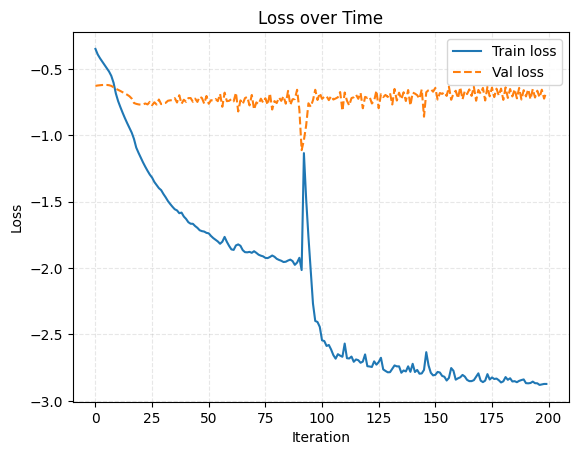

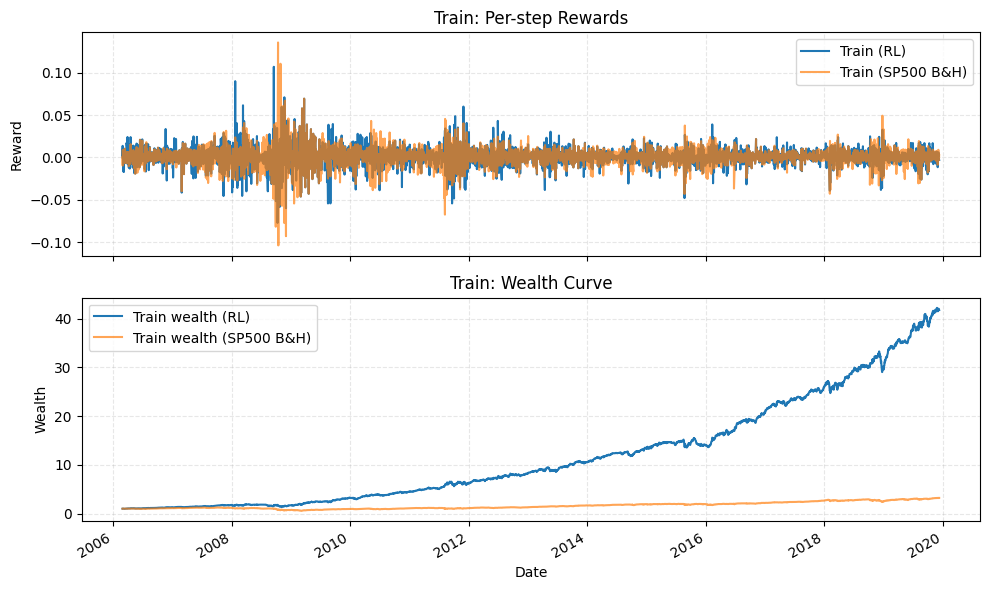

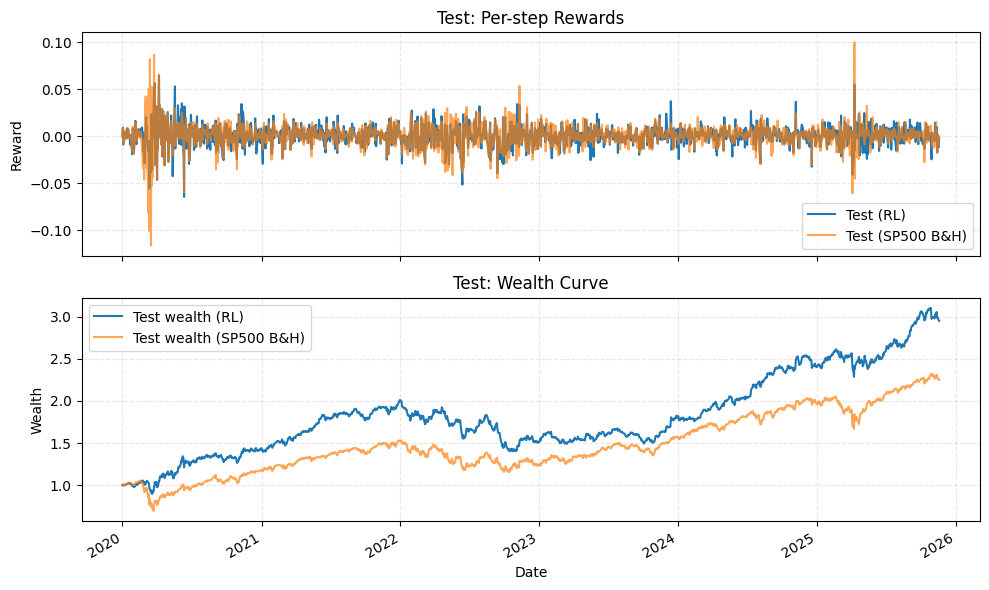

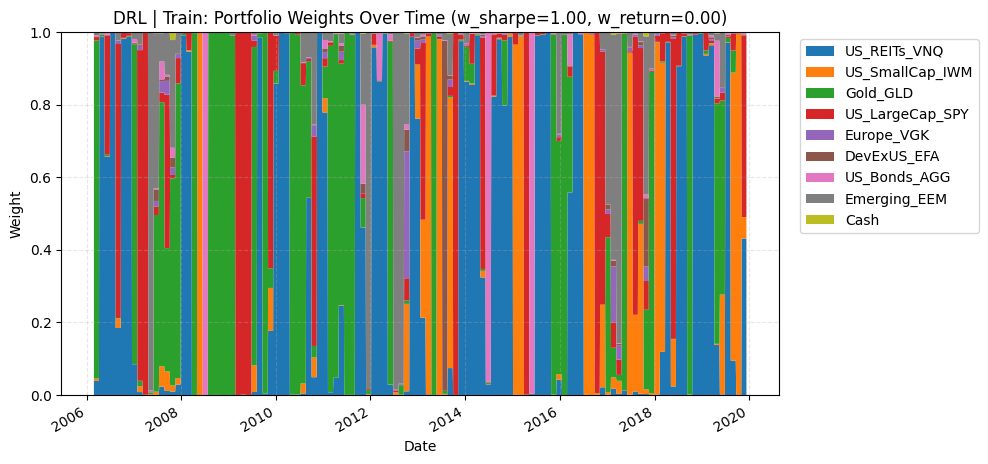

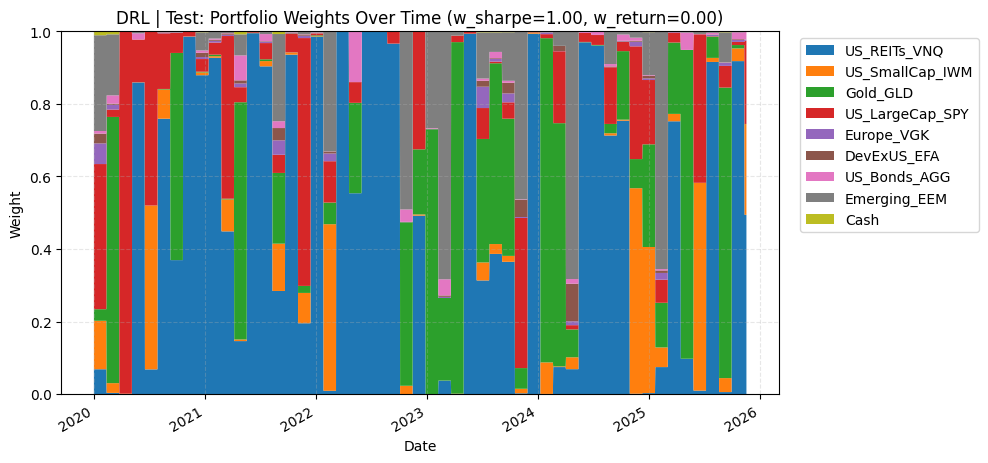

[ES] gen    0 | train_loss=-0.379487 | train_score=0.379487 | val_loss=-0.630602 | val_score=0.630602
[ES] gen   40 | train_loss=-2.900211 | train_score=2.900211 | val_loss=-0.844673 | val_score=0.844673
[ES] gen   80 | train_loss=-2.743517 | train_score=2.743517 | val_loss=-0.619254 | val_score=0.619254
[ES] gen  120 | train_loss=-3.172710 | train_score=3.172710 | val_loss=-0.948772 | val_score=0.948772
[ES] gen  160 | train_loss=-3.398339 | train_score=3.398339 | val_loss=-0.866044 | val_score=0.866044
[ES] elite_train gen  199 | loss=-3.455186 | score=3.455186
ES | w_sharpe=1.00, w_return=0.00
Train metrics: {'total_log_return': 2.5976247787475586, 'total_simple_return': 12.431796627255828, 'mean_daily': 0.0007744425092823803, 'std_daily': 0.010211650282144547, 'mean_ann': 0.19515951233915985, 'sharpe_ann': 1.2039085365832882}
Test metrics:  {'total_log_return': 0.5684705972671509, 'total_simple_return': 0.7655647259715834, 'mean_daily': 0.00043739727698266506, 'std_daily': 0.011542

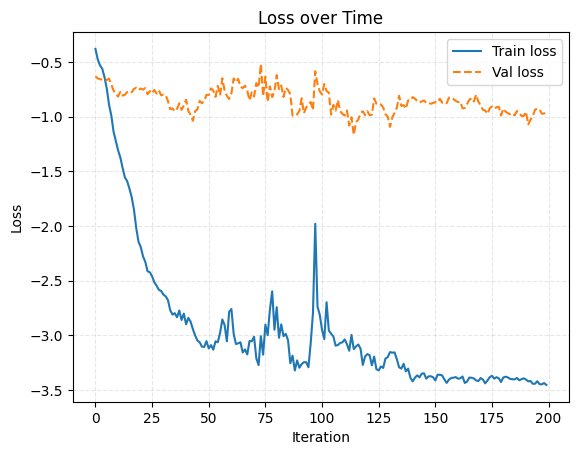

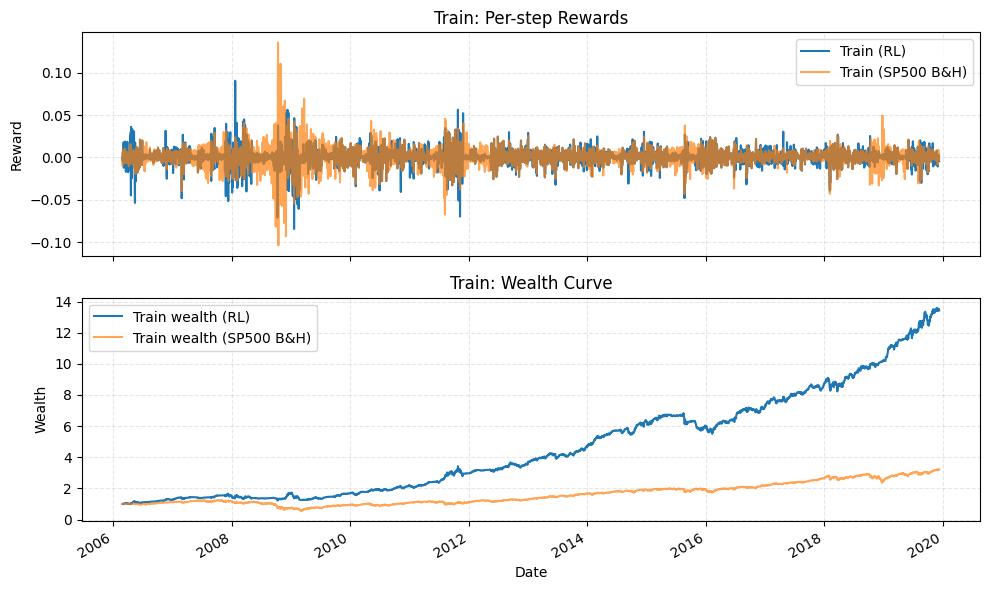

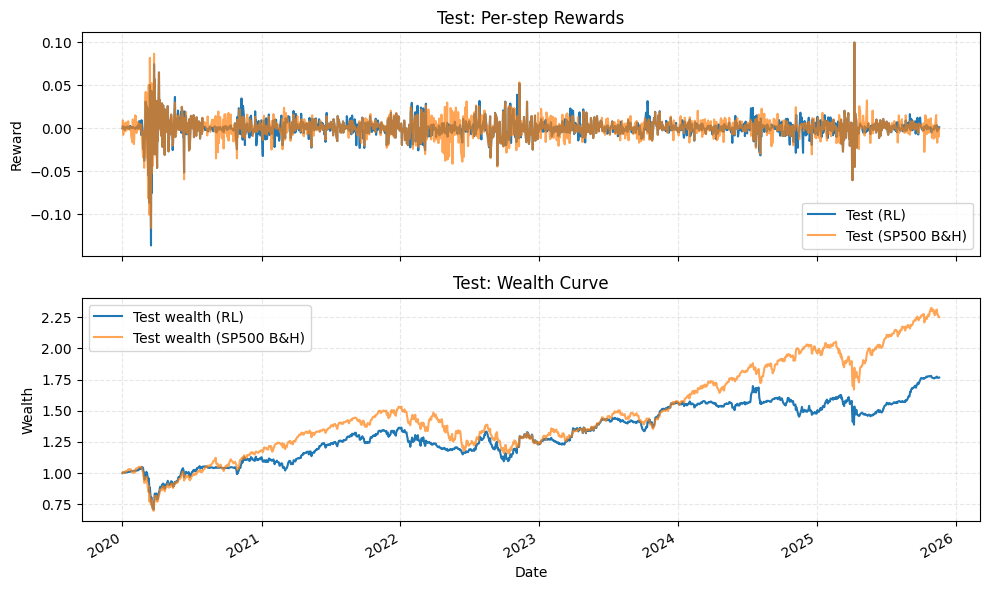

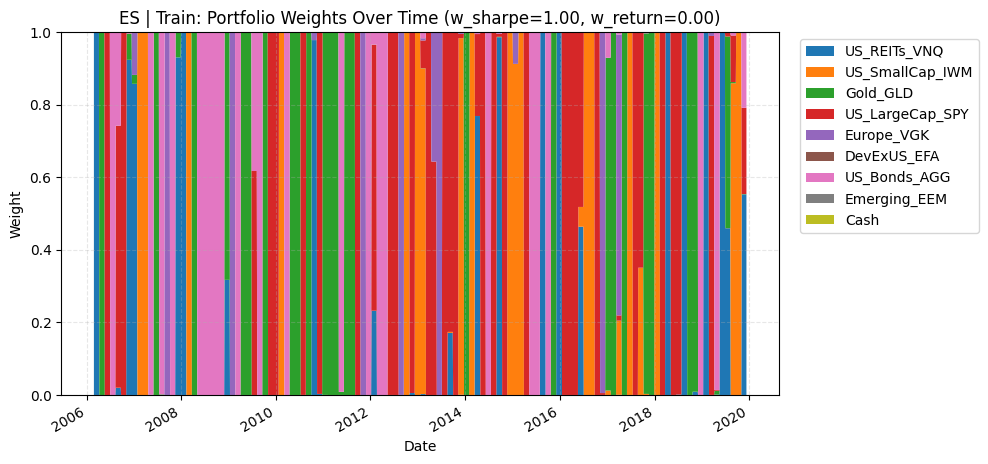

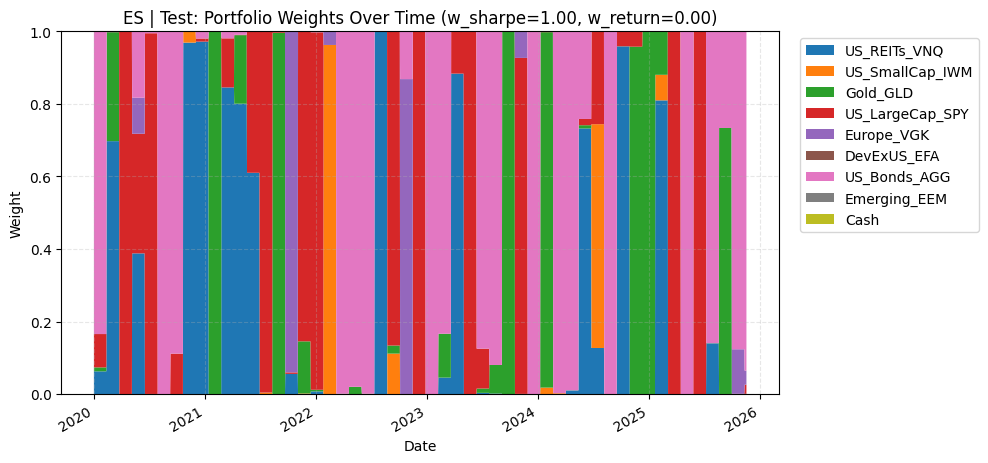

=== weights: w_sharpe=0.80, w_return=0.20 ===
[DRL] iter    0 | train_loss=-0.292498 | train_score=0.292498 | val_loss=-0.518862 | val_score=0.518862
[DRL] iter   40 | train_loss=-1.249200 | train_score=1.249200 | val_loss=-0.606858 | val_score=0.606858
[DRL] iter   80 | train_loss=-1.539886 | train_score=1.539886 | val_loss=-0.632141 | val_score=0.632141
[DRL] iter  120 | train_loss=-1.987017 | train_score=1.987017 | val_loss=-0.599121 | val_score=0.599121
[DRL] iter  160 | train_loss=-2.193990 | train_score=2.193990 | val_loss=-0.580474 | val_score=0.580474
[DRL] elite_train iter  195 | loss=-2.322921 | score=2.322921
DRL | w_sharpe=0.80, w_return=0.20
Train metrics: {'total_log_return': 3.7210946083068848, 'total_simple_return': 40.309587187027766, 'mean_daily': 0.001100531779229641, 'std_daily': 0.01148583460599184, 'mean_ann': 0.2773340083658695, 'sharpe_ann': 1.5210387427407537}
Test metrics:  {'total_log_return': 0.9600455164909363, 'total_simple_return': 1.611815351387412, 'mea

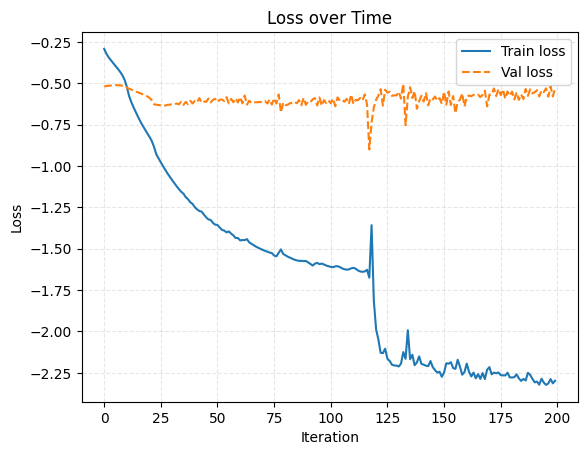

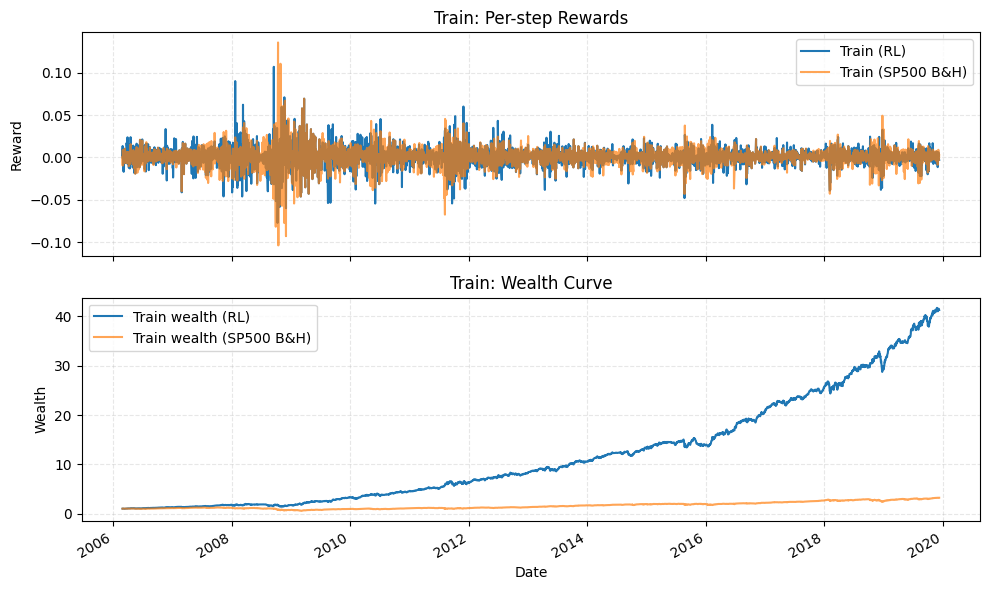

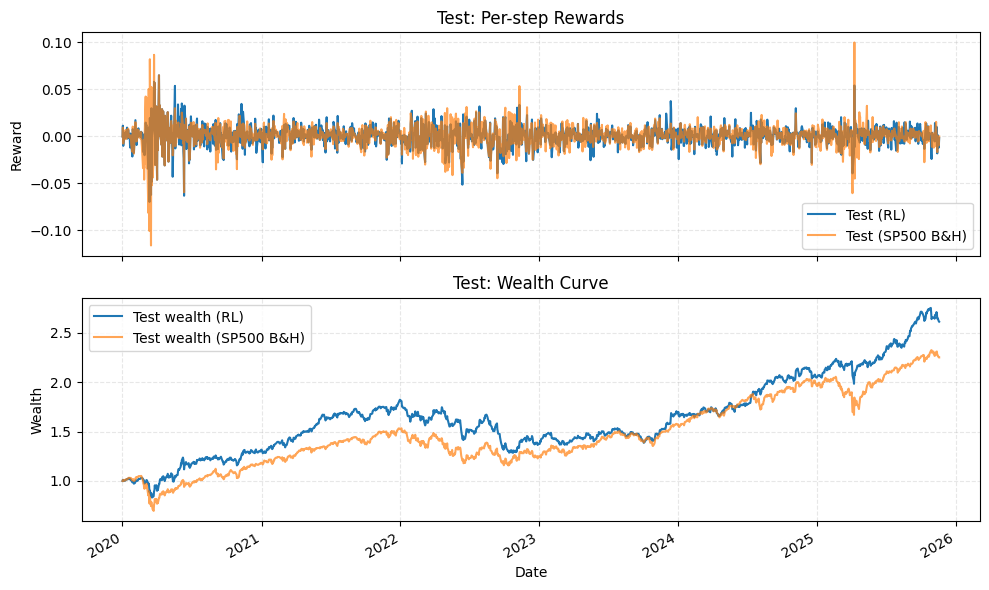

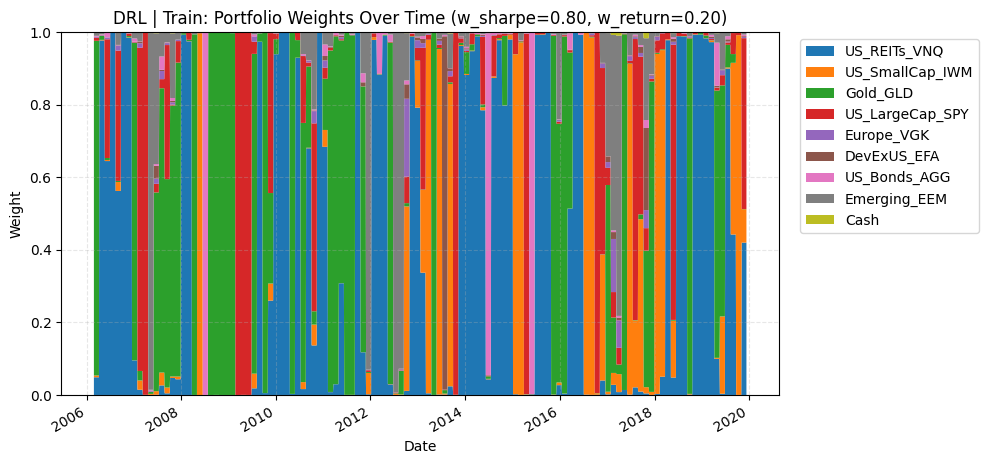

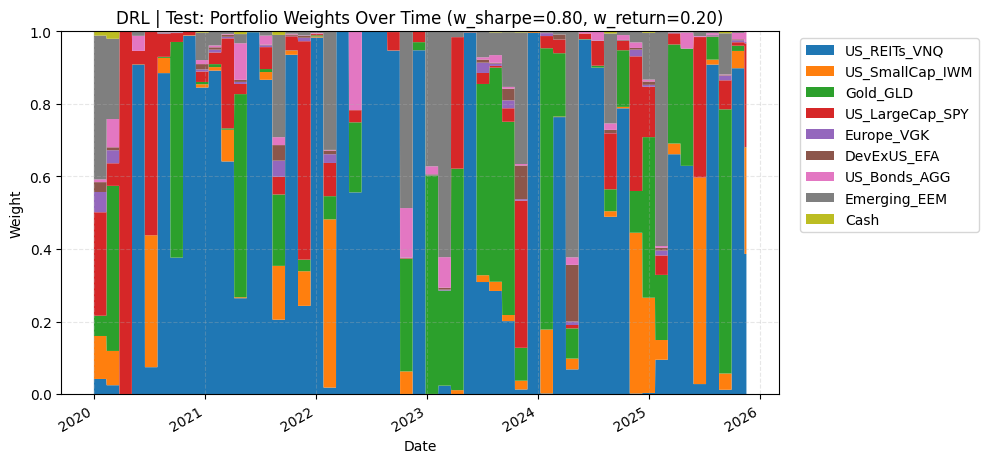

[ES] gen    0 | train_loss=-0.313218 | train_score=0.313218 | val_loss=-0.520402 | val_score=0.520402
[ES] gen   40 | train_loss=-2.245692 | train_score=2.245692 | val_loss=-0.777802 | val_score=0.777802
[ES] gen   80 | train_loss=-2.652626 | train_score=2.652626 | val_loss=-0.668986 | val_score=0.668986
[ES] gen  120 | train_loss=-2.859067 | train_score=2.859067 | val_loss=-0.619348 | val_score=0.619348
[ES] gen  160 | train_loss=-2.918110 | train_score=2.918110 | val_loss=-0.688730 | val_score=0.688730
[ES] elite_train gen  183 | loss=-3.041793 | score=3.041793
ES | w_sharpe=0.80, w_return=0.20
Train metrics: {'total_log_return': 3.123406410217285, 'total_simple_return': 21.72365404160465, 'mean_daily': 0.0009125254582613707, 'std_daily': 0.009389215148985386, 'mean_ann': 0.2299564154818654, 'sharpe_ann': 1.542822415260942}
Test metrics:  {'total_log_return': 0.868645429611206, 'total_simple_return': 1.3836798035977234, 'mean_daily': 0.0006094697746448219, 'std_daily': 0.009304994717

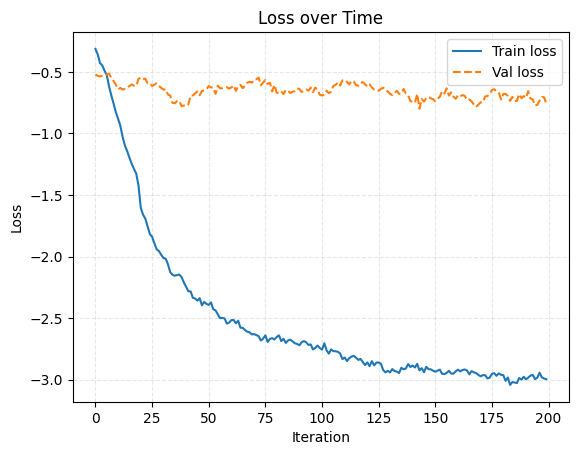

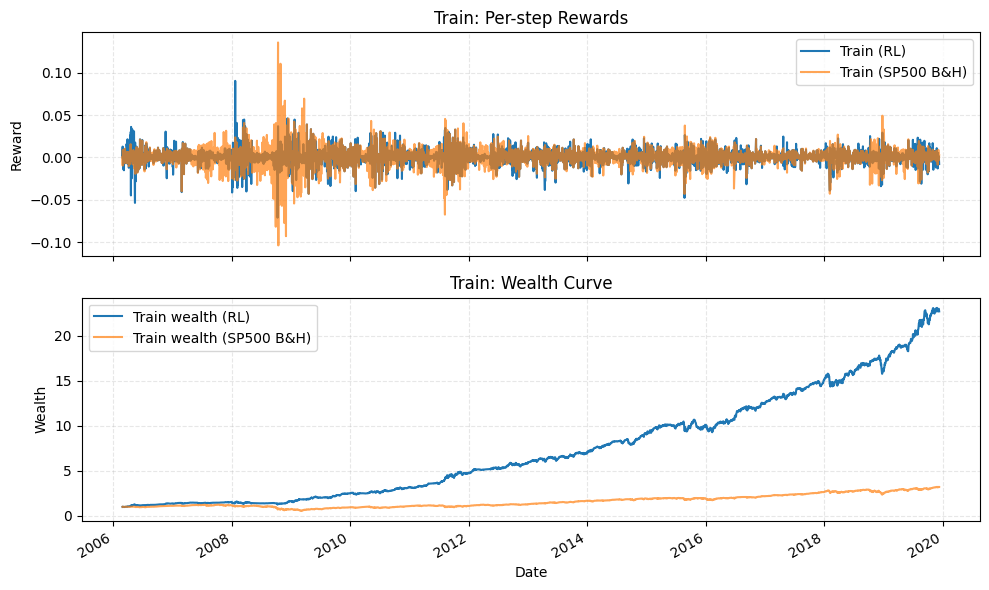

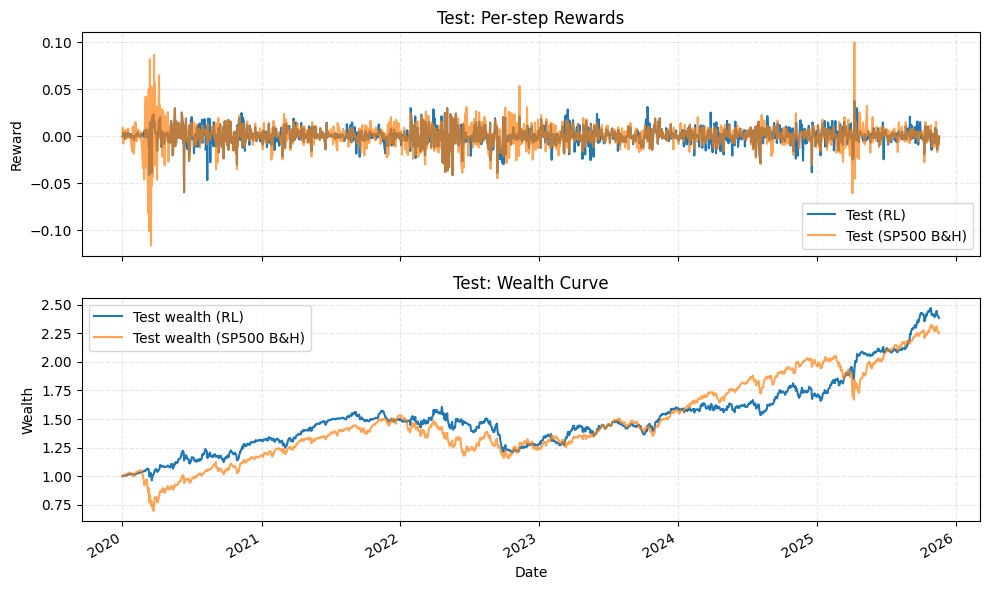

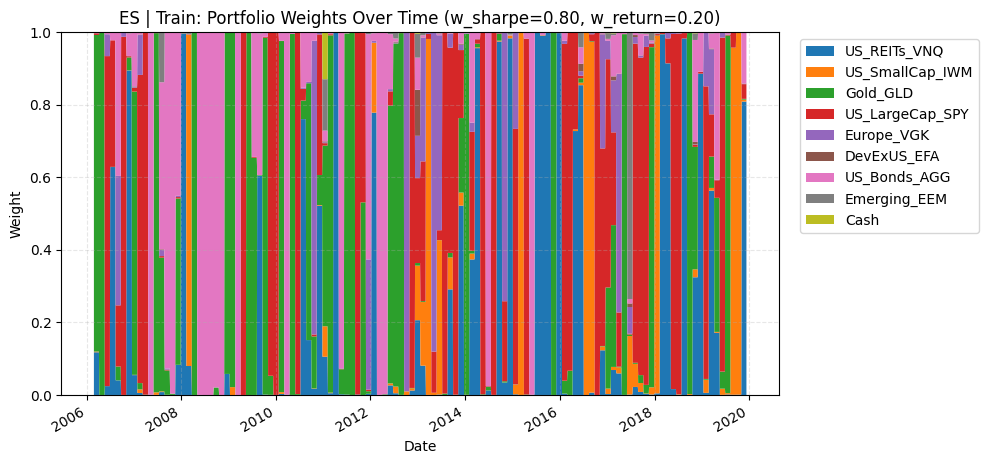

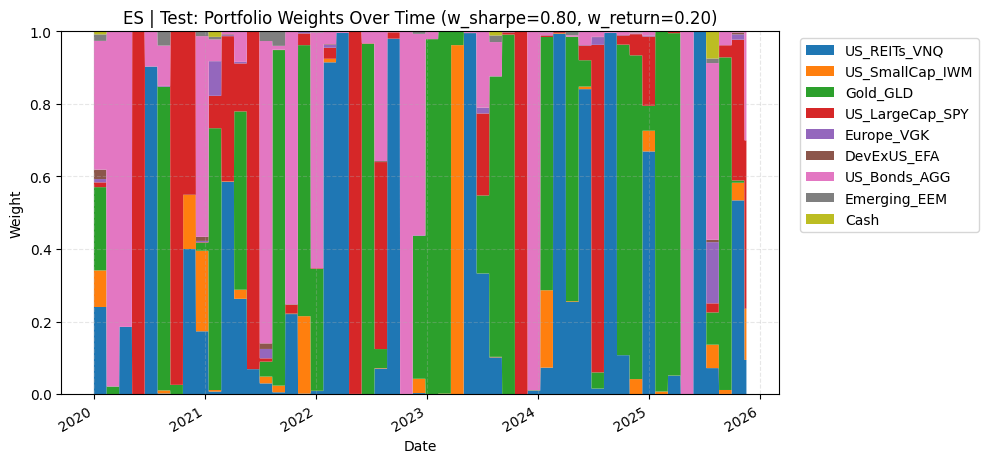

=== weights: w_sharpe=0.60, w_return=0.40 ===
[DRL] iter    0 | train_loss=-0.235117 | train_score=0.235117 | val_loss=-0.409351 | val_score=0.409351
[DRL] iter   40 | train_loss=-0.868250 | train_score=0.868250 | val_loss=-0.498592 | val_score=0.498592
[DRL] iter   80 | train_loss=-1.155503 | train_score=1.155503 | val_loss=-0.477546 | val_score=0.477546
[DRL] iter  120 | train_loss=-1.259618 | train_score=1.259618 | val_loss=-0.487804 | val_score=0.487804
[DRL] iter  160 | train_loss=-1.694098 | train_score=1.694098 | val_loss=-0.434821 | val_score=0.434821
[DRL] elite_train iter  188 | loss=-1.794378 | score=1.794378
DRL | w_sharpe=0.60, w_return=0.40
Train metrics: {'total_log_return': 3.6255016326904297, 'total_simple_return': 36.54355150950026, 'mean_daily': 0.0010715111857280135, 'std_daily': 0.011268150992691517, 'mean_ann': 0.2700208188034594, 'sharpe_ann': 1.5095388592923484}
Test metrics:  {'total_log_return': 0.9817495346069336, 'total_simple_return': 1.66912188049132, 'mea

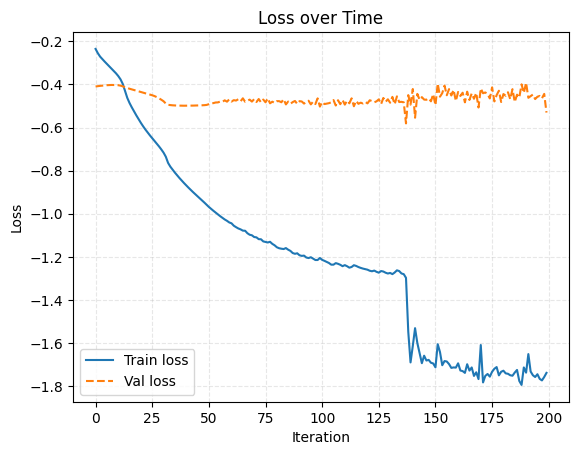

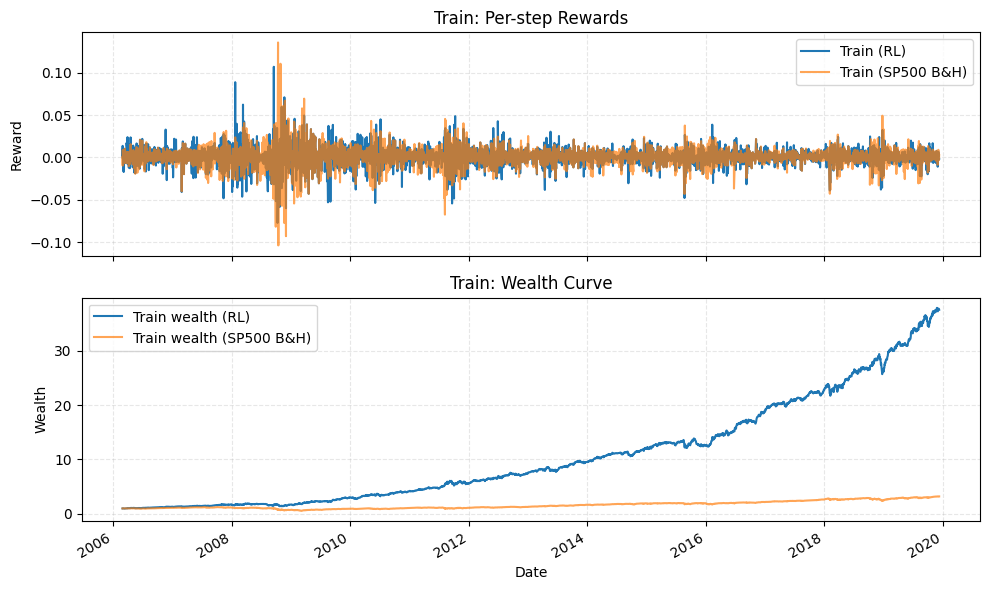

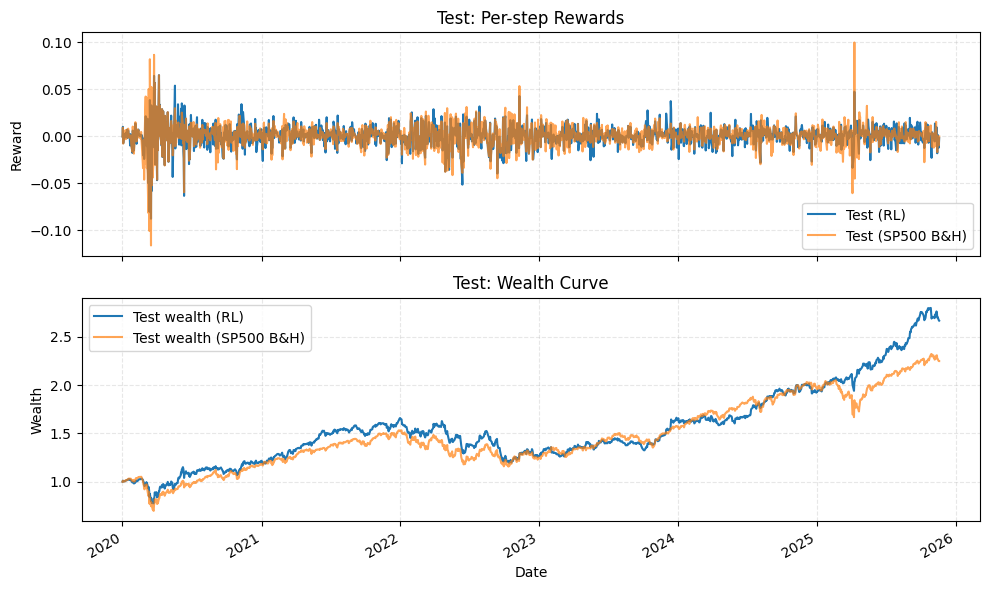

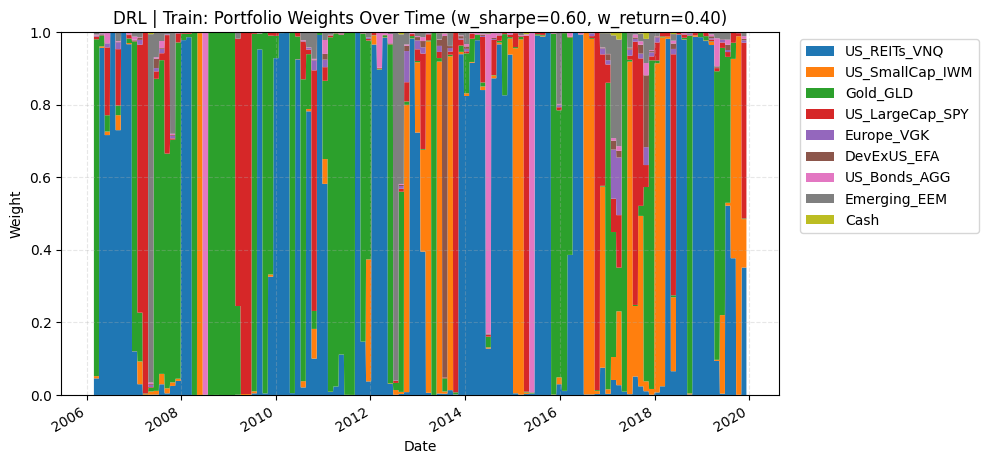

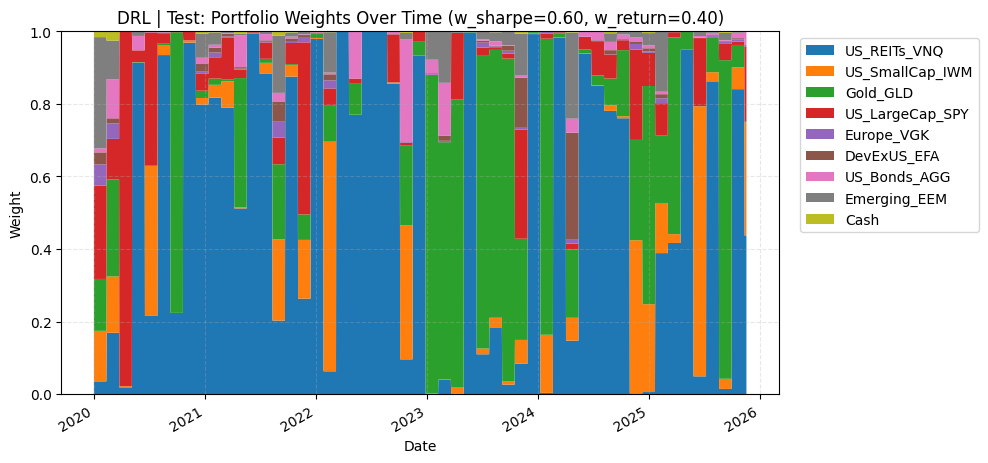

[ES] gen    0 | train_loss=-0.248739 | train_score=0.248739 | val_loss=-0.410218 | val_score=0.410218
[ES] gen   40 | train_loss=-1.555539 | train_score=1.555539 | val_loss=-0.545934 | val_score=0.545934
[ES] gen   80 | train_loss=-2.061538 | train_score=2.061538 | val_loss=-0.544842 | val_score=0.544842
[ES] gen  120 | train_loss=-2.154253 | train_score=2.154253 | val_loss=-0.530817 | val_score=0.530817
[ES] gen  160 | train_loss=-2.257860 | train_score=2.257860 | val_loss=-0.580651 | val_score=0.580651
[ES] elite_train gen  198 | loss=-2.367762 | score=2.367762
ES | w_sharpe=0.60, w_return=0.40
Train metrics: {'total_log_return': 2.9913601875305176, 'total_simple_return': 18.91274915261999, 'mean_daily': 0.0008748799446038902, 'std_daily': 0.009286069311201572, 'mean_ann': 0.22046974604018033, 'sharpe_ann': 1.4956045615407707}
Test metrics:  {'total_log_return': 1.0213680267333984, 'total_simple_return': 1.7769911647351146, 'mean_daily': 0.0007153528276830912, 'std_daily': 0.00998514

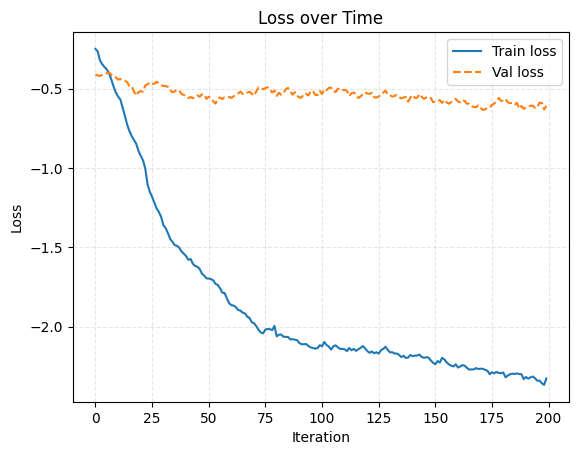

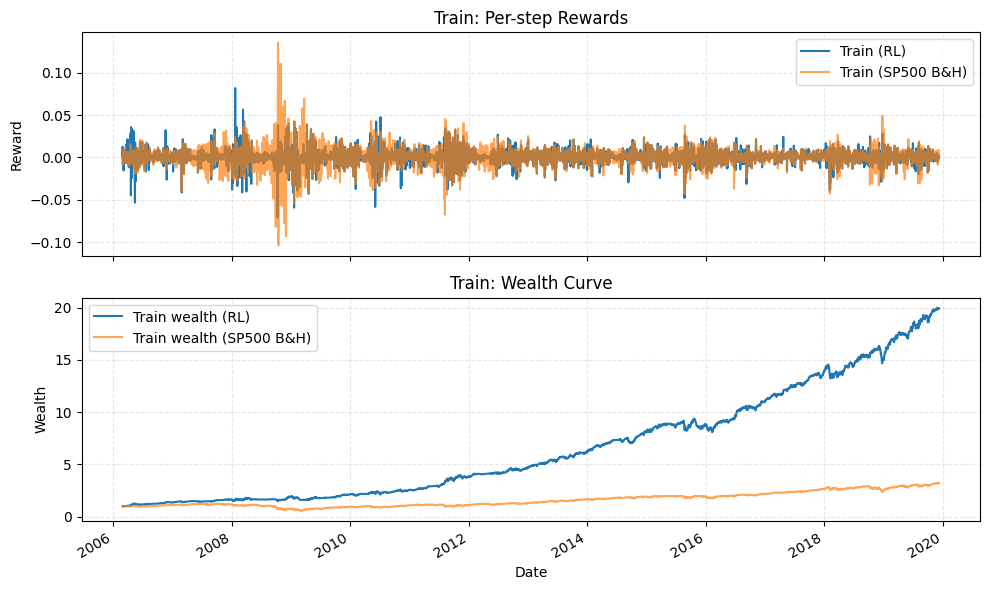

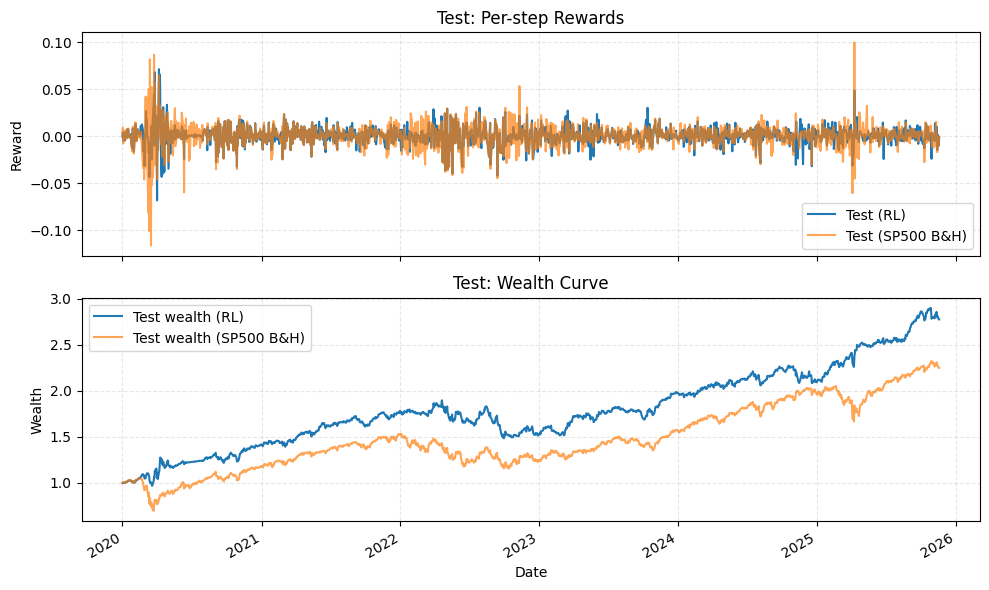

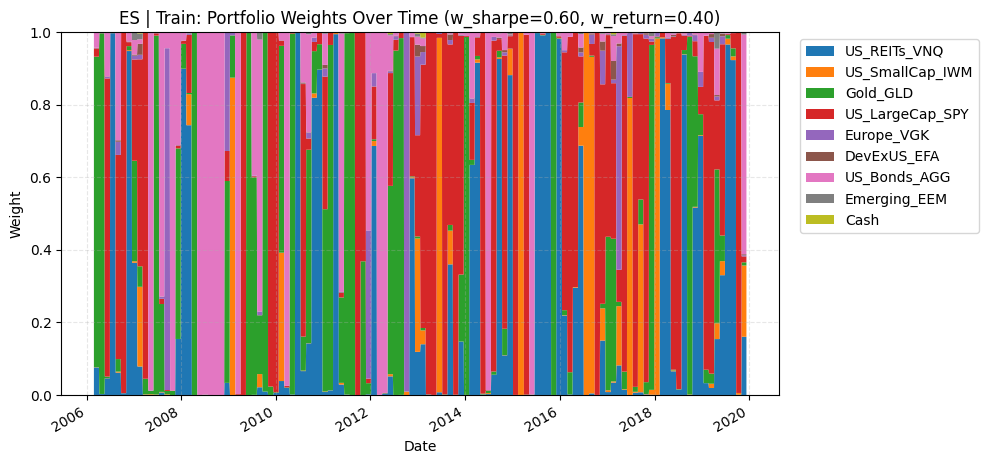

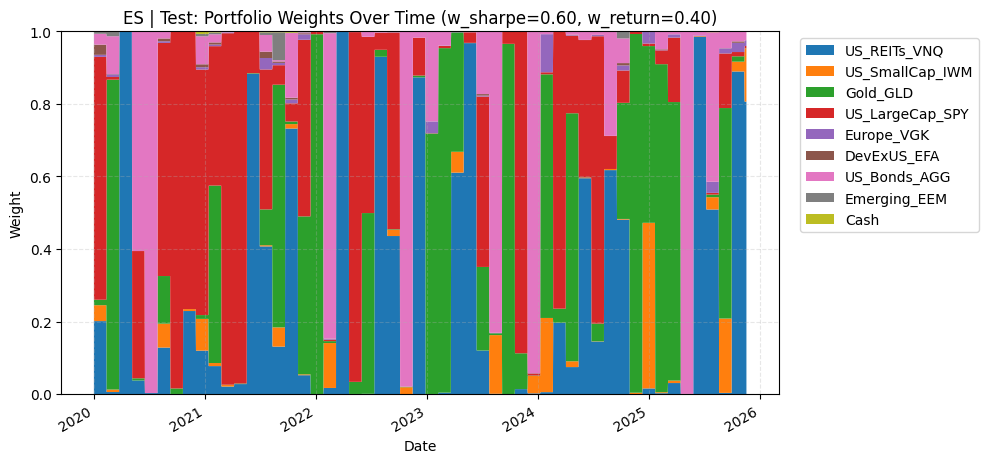

=== weights: w_sharpe=0.40, w_return=0.60 ===
[DRL] iter    0 | train_loss=-0.177736 | train_score=0.177736 | val_loss=-0.299657 | val_score=0.299657
[DRL] iter   40 | train_loss=-0.521142 | train_score=0.521142 | val_loss=-0.332847 | val_score=0.332847
[DRL] iter   80 | train_loss=-0.745772 | train_score=0.745772 | val_loss=-0.363459 | val_score=0.363459
[DRL] iter  120 | train_loss=-0.854364 | train_score=0.854364 | val_loss=-0.368794 | val_score=0.368794
[DRL] iter  160 | train_loss=-0.906441 | train_score=0.906441 | val_loss=-0.362933 | val_score=0.362933
[DRL] elite_train iter  199 | loss=-0.939417 | score=0.939417
DRL | w_sharpe=0.40, w_return=0.60
Train metrics: {'total_log_return': 3.3850927352905273, 'total_simple_return': 28.520730202710652, 'mean_daily': 0.0010313846869394183, 'std_daily': 0.013391370885074139, 'mean_ann': 0.2599089411087334, 'sharpe_ann': 1.2226323724745978}
Test metrics:  {'total_log_return': 0.8125918507575989, 'total_simple_return': 1.2537417855970232, '

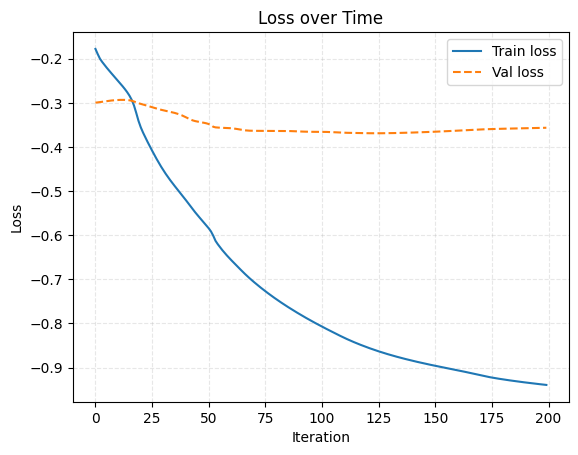

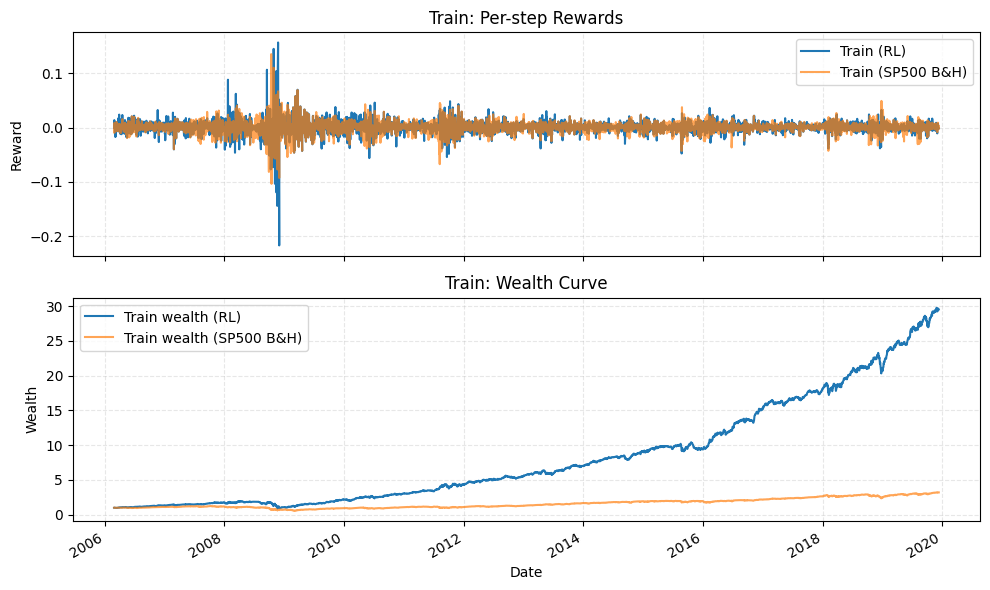

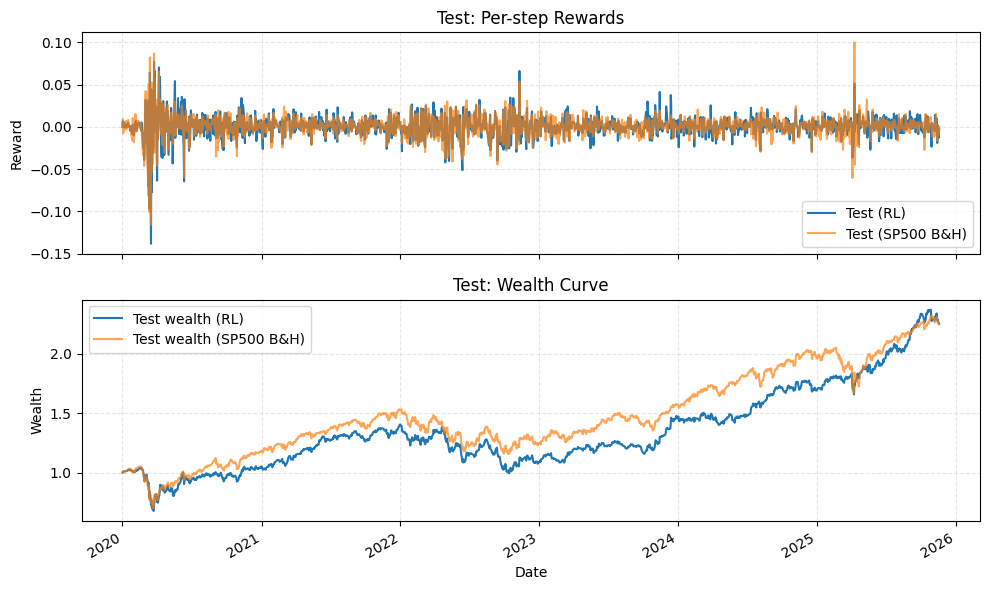

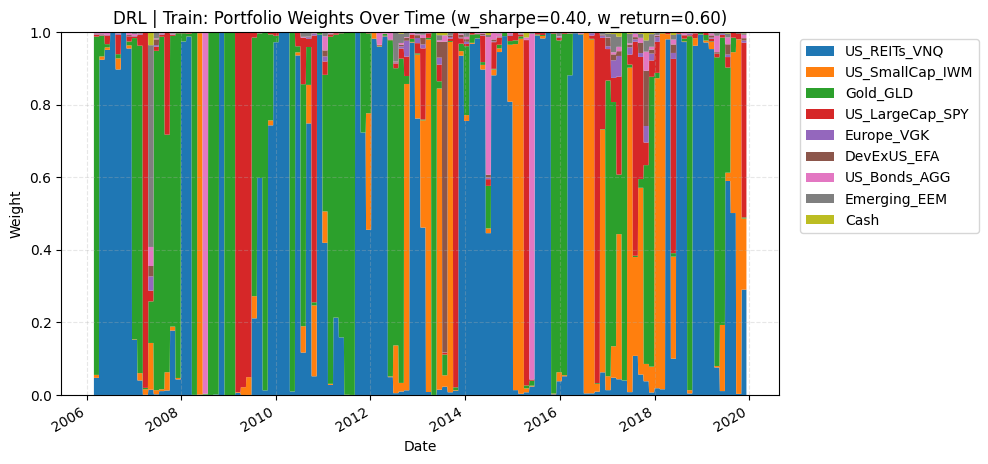

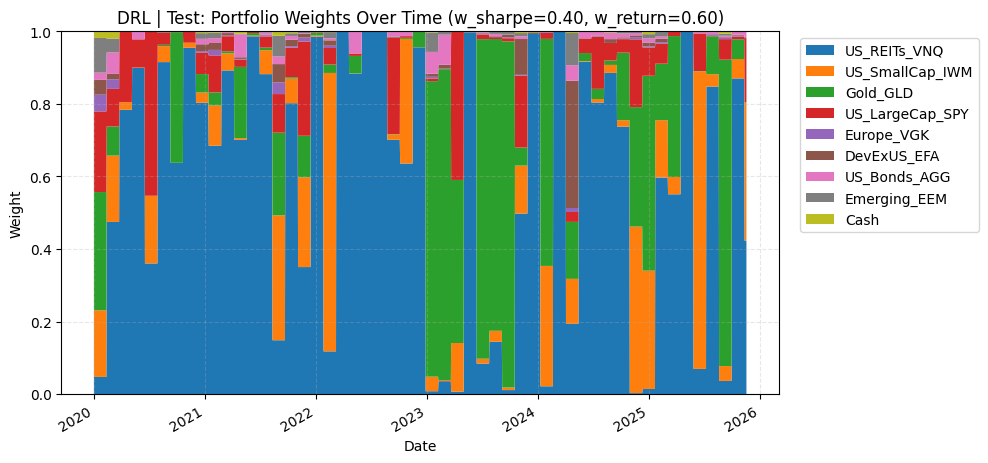

[ES] gen    0 | train_loss=-0.185861 | train_score=0.185861 | val_loss=-0.300052 | val_score=0.300052
[ES] gen   40 | train_loss=-0.878954 | train_score=0.878954 | val_loss=-0.371479 | val_score=0.371479
[ES] gen   80 | train_loss=-1.298854 | train_score=1.298854 | val_loss=-0.381079 | val_score=0.381079
[ES] gen  120 | train_loss=-1.467424 | train_score=1.467424 | val_loss=-0.375390 | val_score=0.375390
[ES] gen  160 | train_loss=-1.561826 | train_score=1.561826 | val_loss=-0.411809 | val_score=0.411809
[ES] elite_train gen  197 | loss=-1.624789 | score=1.624789
ES | w_sharpe=0.40, w_return=0.60
Train metrics: {'total_log_return': 3.135190963745117, 'total_simple_return': 21.99302625722206, 'mean_daily': 0.0009127877419814467, 'std_daily': 0.009061146527528763, 'mean_ann': 0.23002251097932458, 'sharpe_ann': 1.599141470567745}
Test metrics:  {'total_log_return': 0.7139868140220642, 'total_simple_return': 1.0421165898471987, 'mean_daily': 0.0005047199665568769, 'std_daily': 0.0088762510

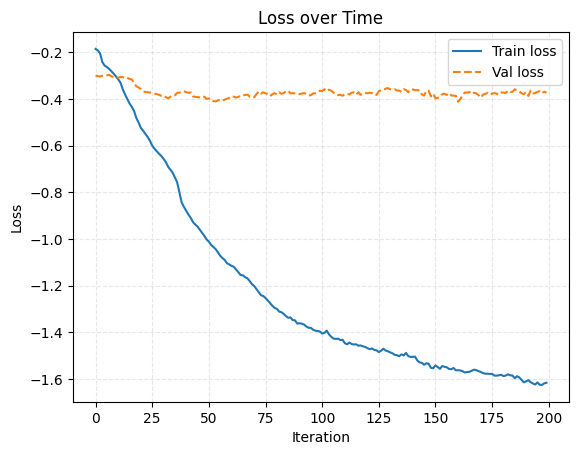

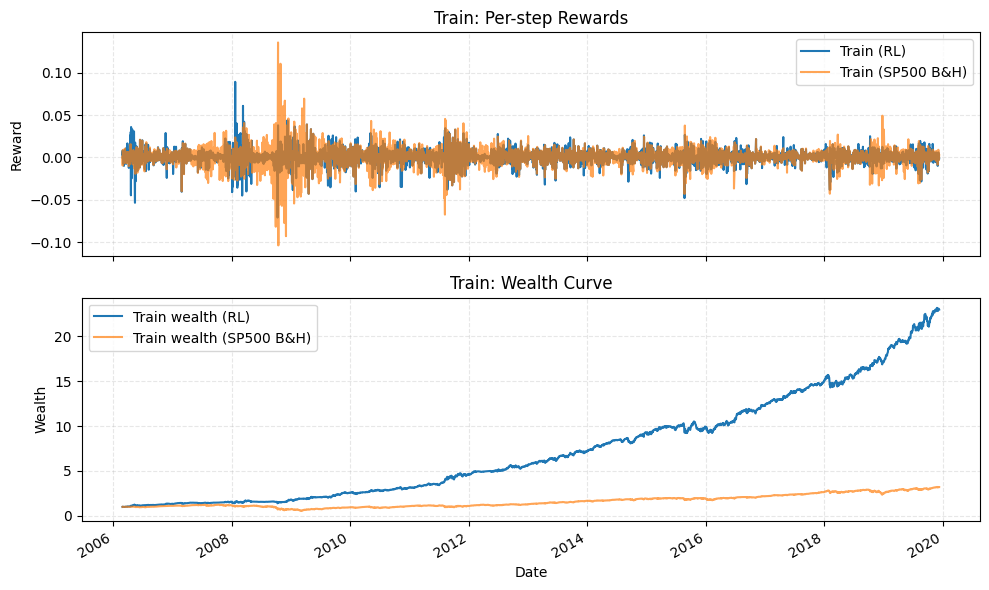

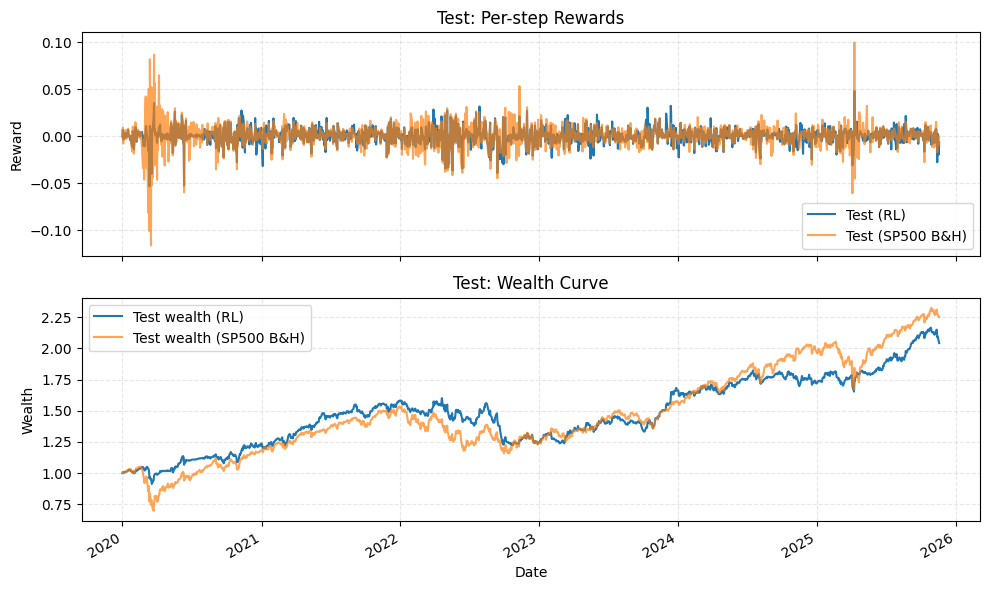

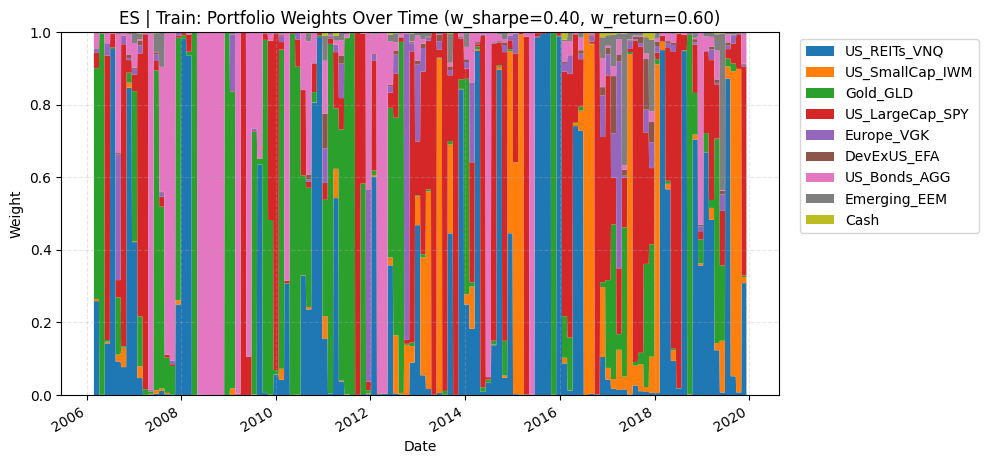

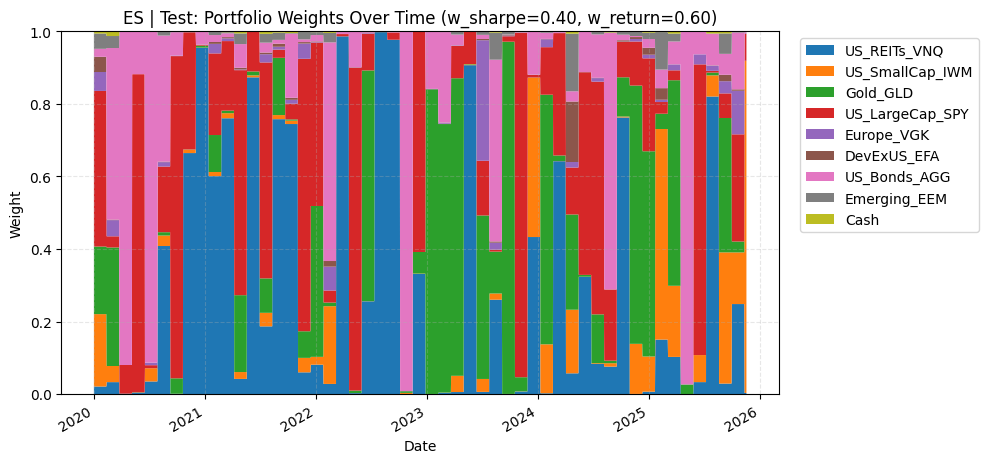

=== weights: w_sharpe=0.20, w_return=0.80 ===
[DRL] iter    0 | train_loss=-0.120355 | train_score=0.120355 | val_loss=-0.189772 | val_score=0.189772
[DRL] iter   40 | train_loss=-0.268233 | train_score=0.268233 | val_loss=-0.191019 | val_score=0.191019
[DRL] iter   80 | train_loss=-0.384001 | train_score=0.384001 | val_loss=-0.216103 | val_score=0.216103
[DRL] iter  120 | train_loss=-0.463173 | train_score=0.463173 | val_loss=-0.227667 | val_score=0.227667
[DRL] iter  160 | train_loss=-0.511692 | train_score=0.511692 | val_loss=-0.236002 | val_score=0.236002
[DRL] elite_train iter  199 | loss=-0.539731 | score=0.539731
DRL | w_sharpe=0.20, w_return=0.80
Train metrics: {'total_log_return': 3.2958199977874756, 'total_simple_return': 25.99954456198618, 'mean_daily': 0.0010215193033218384, 'std_daily': 0.014503341168165207, 'mean_ann': 0.25742286443710327, 'sharpe_ann': 1.1180951564119468}
Test metrics:  {'total_log_return': 0.7685088515281677, 'total_simple_return': 1.1565481215888211, '

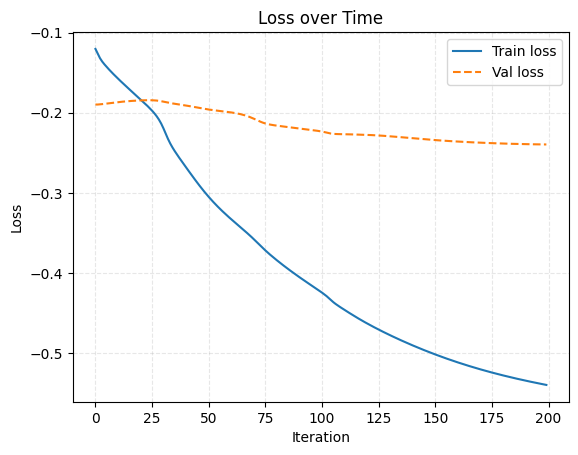

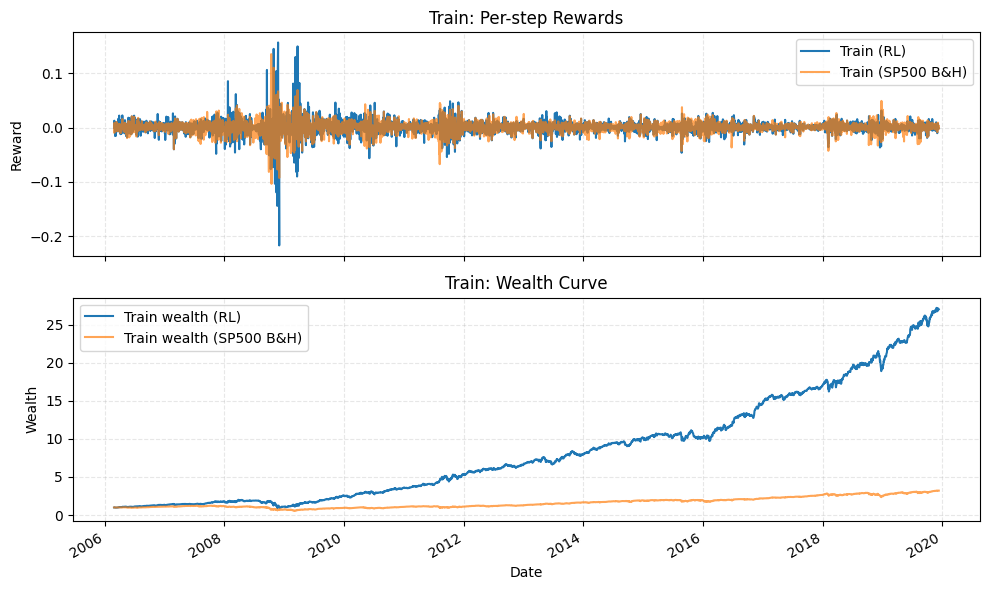

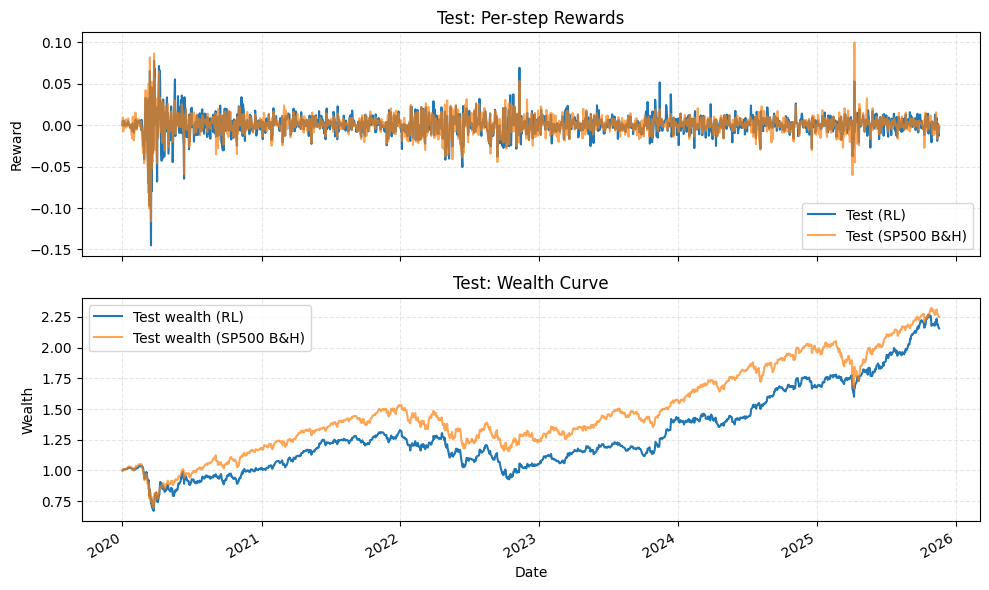

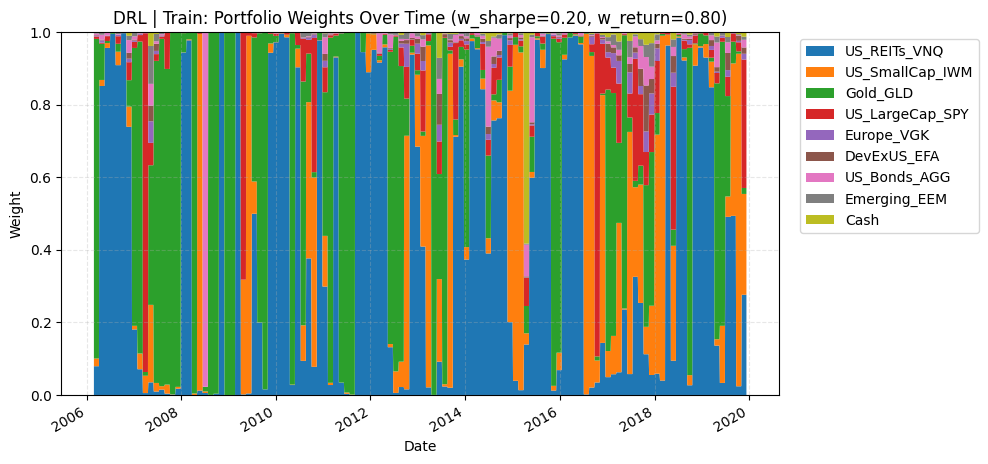

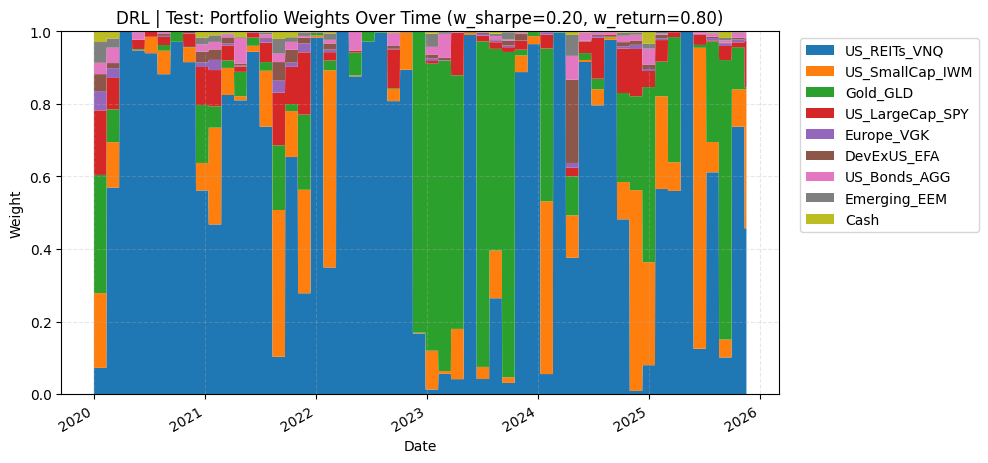

[ES] gen    0 | train_loss=-0.124480 | train_score=0.124480 | val_loss=-0.189906 | val_score=0.189906
[ES] gen   40 | train_loss=-0.319470 | train_score=0.319470 | val_loss=-0.215143 | val_score=0.215143
[ES] gen   80 | train_loss=-0.487839 | train_score=0.487839 | val_loss=-0.255375 | val_score=0.255375
[ES] gen  120 | train_loss=-0.643787 | train_score=0.643787 | val_loss=-0.235593 | val_score=0.235593
[ES] gen  160 | train_loss=-0.732054 | train_score=0.732054 | val_loss=-0.245557 | val_score=0.245557
[ES] elite_train gen  199 | loss=-0.776190 | score=0.776190
ES | w_sharpe=0.20, w_return=0.80
Train metrics: {'total_log_return': 3.556551218032837, 'total_simple_return': 34.042135821931815, 'mean_daily': 0.0010350680677220225, 'std_daily': 0.009603350423276424, 'mean_ann': 0.2608371530659497, 'sharpe_ann': 1.7109856853348286}
Test metrics:  {'total_log_return': 0.8257721662521362, 'total_simple_return': 1.2836434370979353, 'mean_daily': 0.0005870357272215188, 'std_daily': 0.009874711

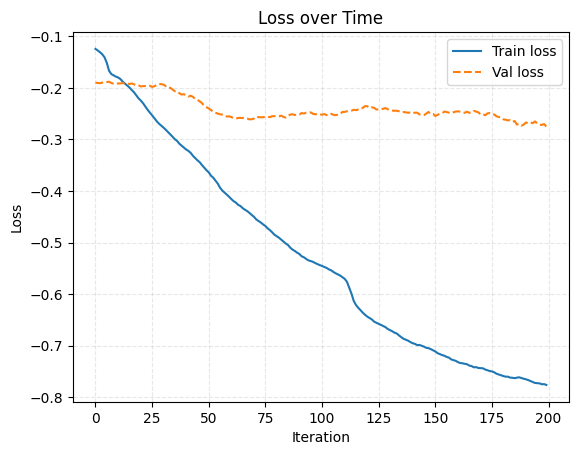

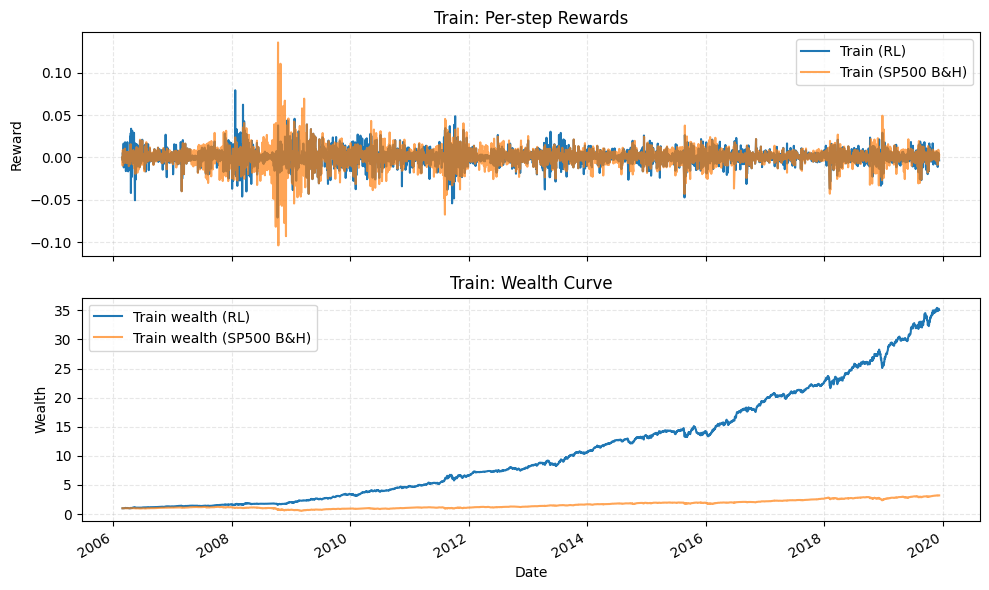

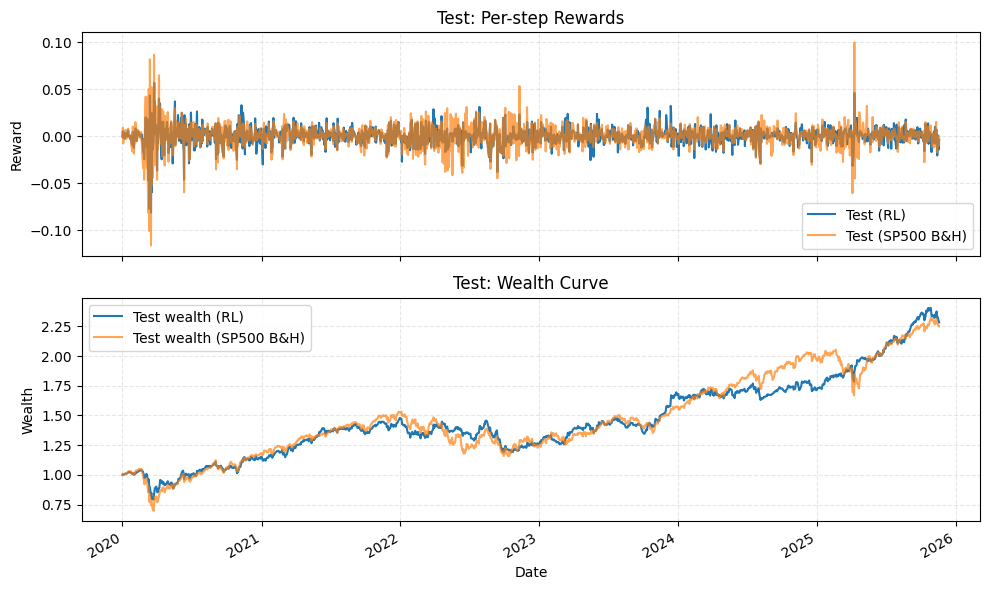

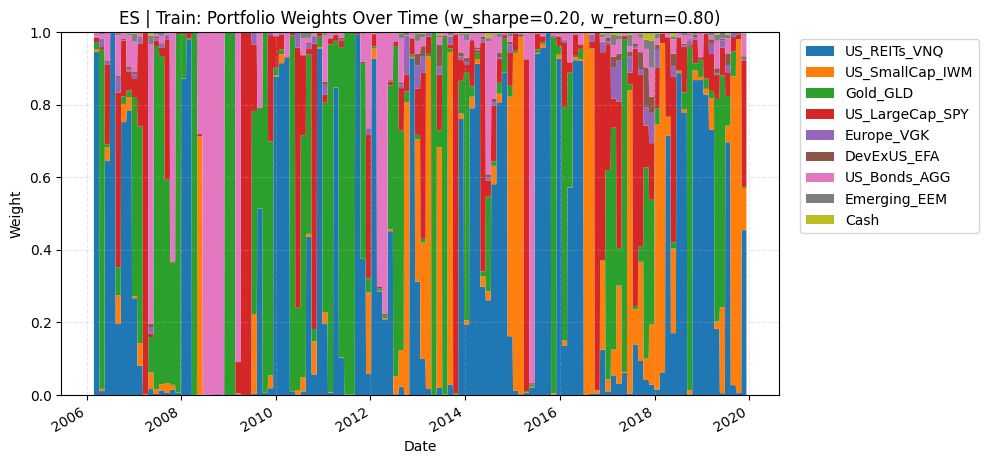

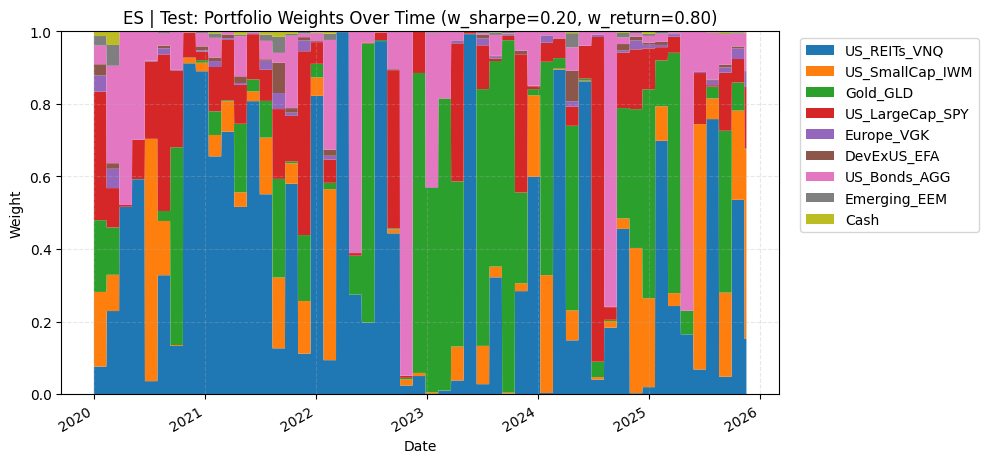

=== weights: w_sharpe=0.00, w_return=1.00 ===
[DRL] iter    0 | train_loss=-0.062974 | train_score=0.062974 | val_loss=-0.079687 | val_score=0.079687
[DRL] iter   40 | train_loss=-0.101969 | train_score=0.101969 | val_loss=-0.078265 | val_score=0.078265
[DRL] iter   80 | train_loss=-0.125372 | train_score=0.125372 | val_loss=-0.077108 | val_score=0.077108
[DRL] iter  120 | train_loss=-0.157994 | train_score=0.157994 | val_loss=-0.080973 | val_score=0.080973
[DRL] iter  160 | train_loss=-0.181439 | train_score=0.181439 | val_loss=-0.085199 | val_score=0.085199
[DRL] elite_train iter  199 | loss=-0.197912 | score=0.197912
DRL | w_sharpe=0.00, w_return=1.00
Train metrics: {'total_log_return': 2.6345672607421875, 'total_simple_return': 12.937279949822917, 'mean_daily': 0.000859373714774847, 'std_daily': 0.015929119661450386, 'mean_ann': 0.21656217612326145, 'sharpe_ann': 0.8564273824168951}
Test metrics:  {'total_log_return': 0.4236738681793213, 'total_simple_return': 0.5275633255293501, '

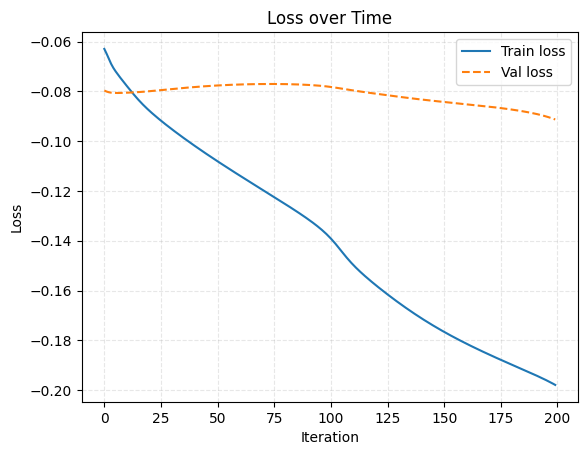

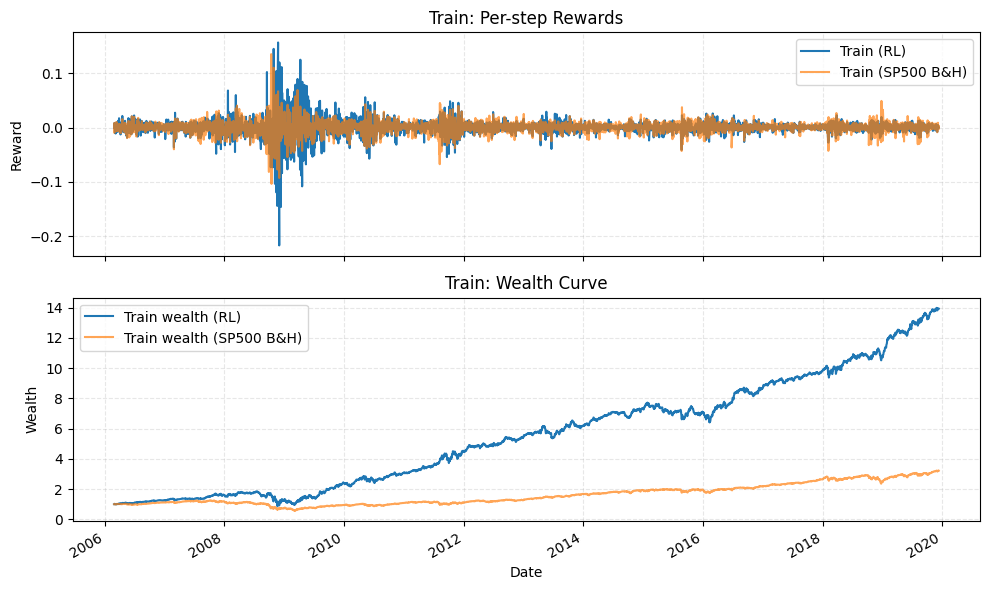

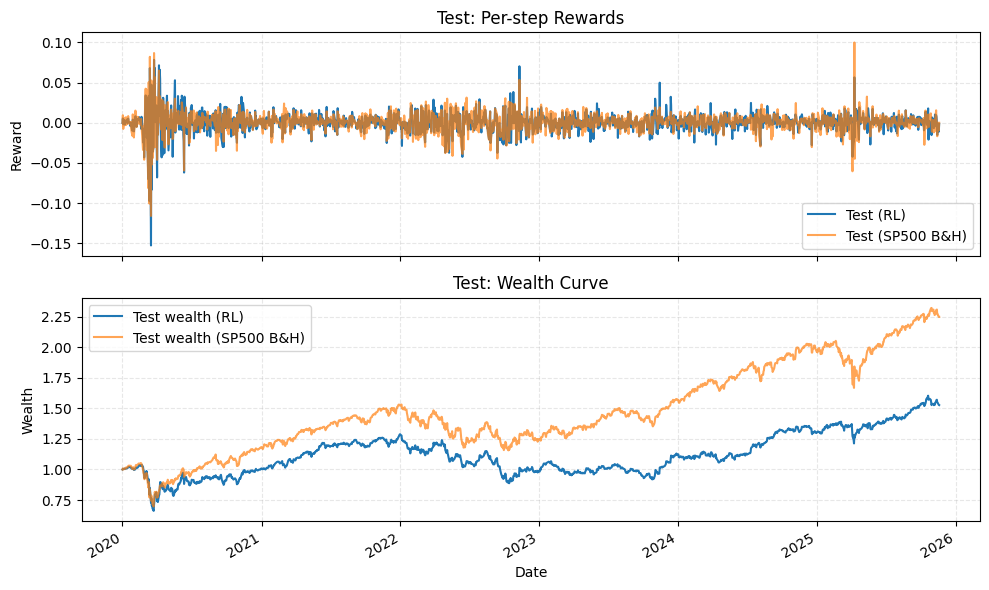

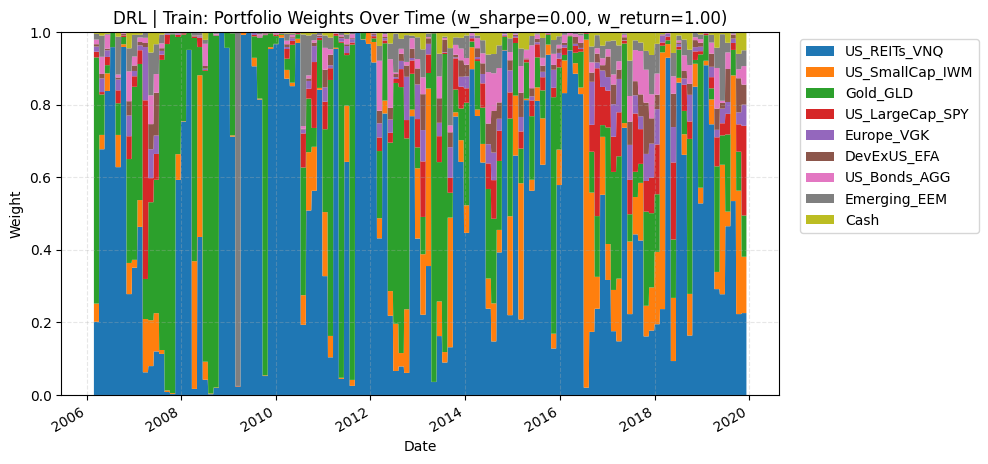

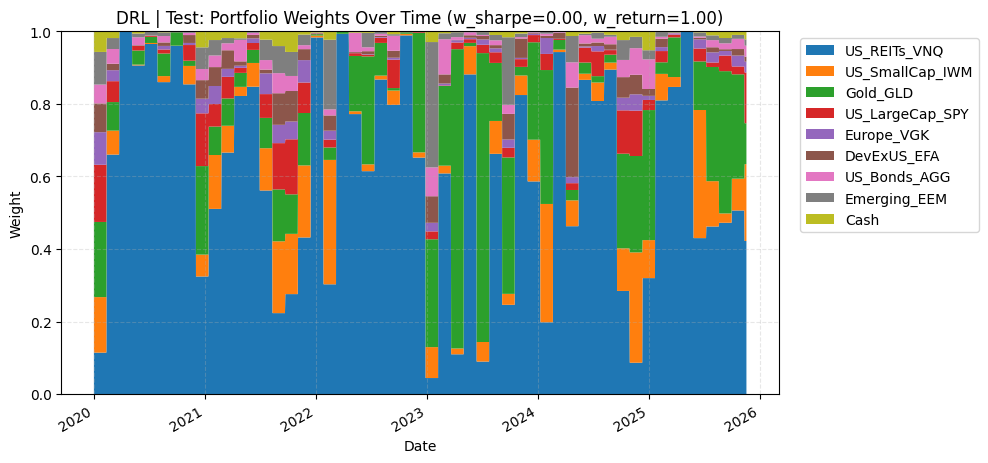

[ES] gen    0 | train_loss=-0.064546 | train_score=0.064546 | val_loss=-0.079779 | val_score=0.079779
[ES] gen   40 | train_loss=-0.105873 | train_score=0.105873 | val_loss=-0.078349 | val_score=0.078349
[ES] gen   80 | train_loss=-0.128240 | train_score=0.128240 | val_loss=-0.078705 | val_score=0.078705
[ES] gen  120 | train_loss=-0.152099 | train_score=0.152099 | val_loss=-0.081813 | val_score=0.081813
[ES] gen  160 | train_loss=-0.175962 | train_score=0.175962 | val_loss=-0.088109 | val_score=0.088109
[ES] elite_train gen  199 | loss=-0.201447 | score=0.201447
ES | w_sharpe=0.00, w_return=1.00
Train metrics: {'total_log_return': 2.922806739807129, 'total_simple_return': 17.59340112988009, 'mean_daily': 0.0009073095279745758, 'std_daily': 0.01379901822656393, 'mean_ann': 0.2286420010495931, 'sharpe_ann': 1.0437765459166177}
Test metrics:  {'total_log_return': 0.5543813705444336, 'total_simple_return': 0.7408637020248128, 'mean_daily': 0.0004329507355578244, 'std_daily': 0.01195327099

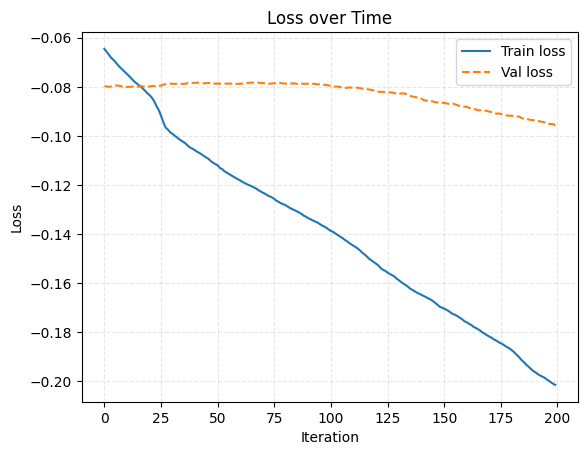

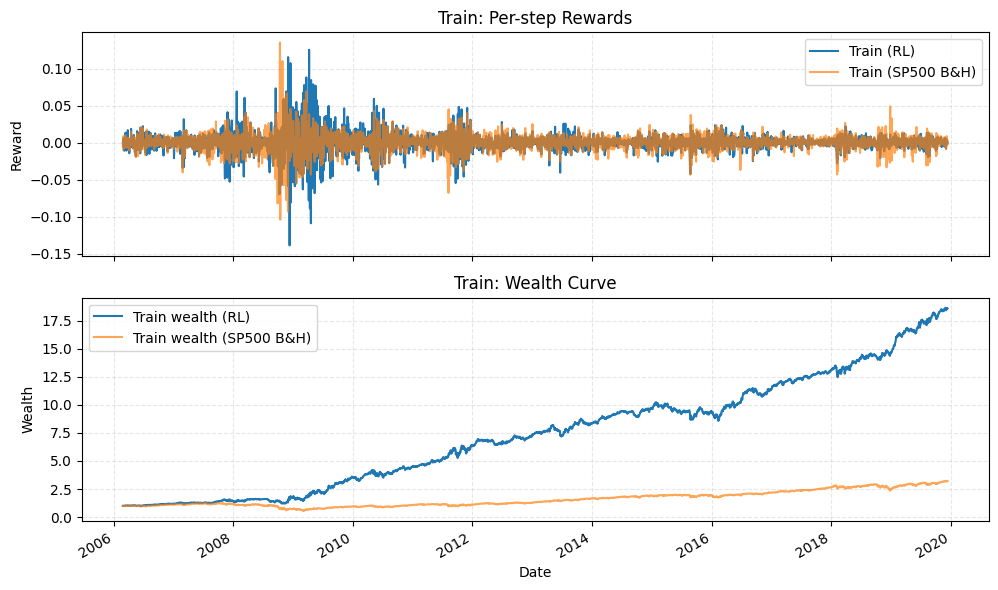

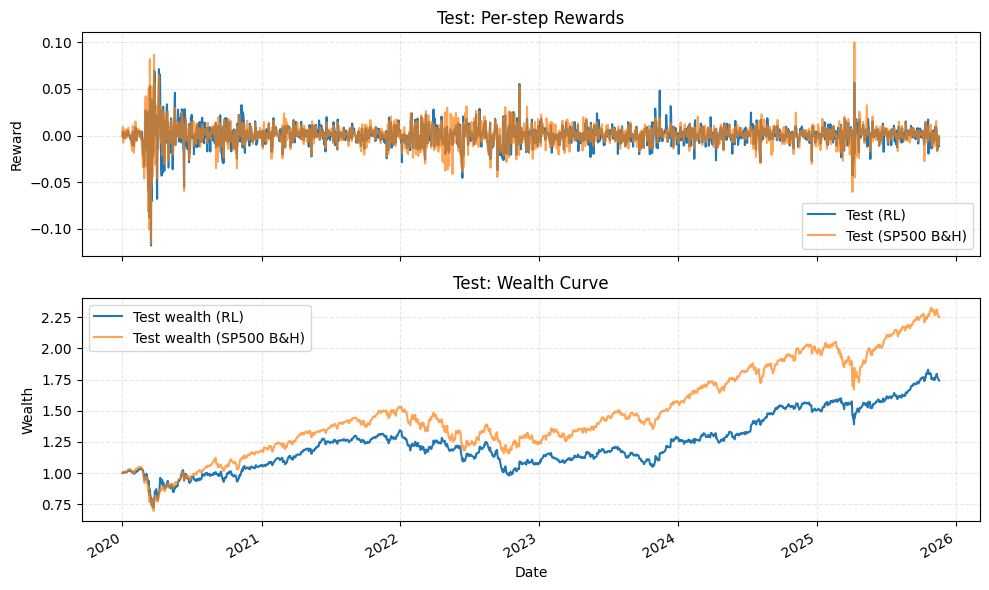

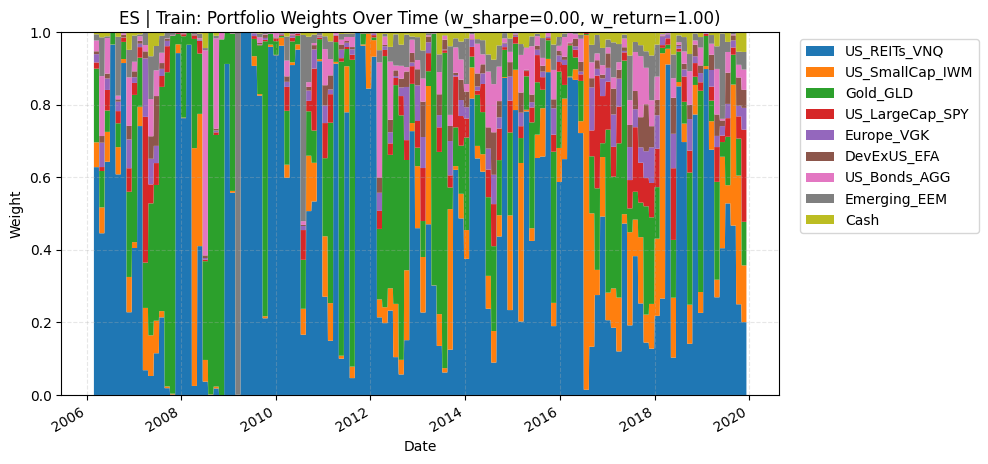

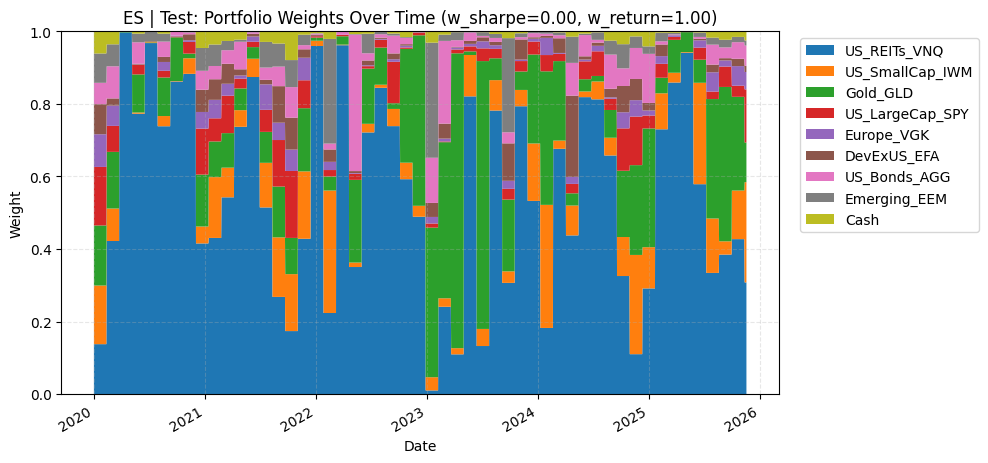

Saved sweep results to: c:\Users\pazer\Desktop\RU\1\CAS\final_project\runs_data\sharpe_return_sweep_20260101_161509_384984


algo  w_sharpe  w_return  train_total_log_return  \
0   DRL       1.0       0.0                3.732258   
2   DRL       0.8       0.2                3.721095   
4   DRL       0.6       0.4                3.625502   
6   DRL       0.4       0.6                3.385093   
8   DRL       0.2       0.8                3.295820   
10  DRL       0.0       1.0                2.634567   
1    ES       1.0       0.0                2.597625   
3    ES       0.8       0.2                3.123406   
5    ES       0.6       0.4                2.991360   
7    ES       0.4       0.6                3.135191   
9    ES       0.2       0.8                3.556551   
11   ES       0.0       1.0                2.922807   

    train_total_simple_return  train_mean_daily  train_std_daily  \
0                   40.773339          0.001103         0.011438   
2                   40.309587          0.001101         0.011486   
4                   36.543552          0.001072         0.011268   
6                   28.520730          0.001031         0.013391   
8                   25.999545          0.001022         0.014503   
10                  12.937280          0.000859         0.015929   
1                   12.431797          0.000774         0.010212   
3                   21.723654          0.000913         0.009389   
5                   18.912749          0.000875         0.009286   
7                   21.993026          0.000913         0.009061   
9                   34.042136          0.001035         0.009603   
11                  17.593401          0.000907         0.013799   

    train_mean_ann  train_sharpe_ann  test_total_log_return  \
0         0.277978          1.530995               1.082027   
2         0.277334          1.521039               0.960046   
4         0.270021          1.509539               0.981750   
6         0.259909          1.222632               0.812592   
8         0.257423          1.118095               0.768509   
10        0.216562          0.856427               0.423674   
1         0.195160          1.203909               0.568471   
3         0.229956          1.542822               0.868645   
5         0.220470          1.495605               1.021368   
7         0.230023          1.599141               0.713987   
9         0.260837          1.710986               0.825772   
11        0.228642          1.043777               0.554381   

    test_total_simple_return  test_mean_daily  test_std_daily  test_mean_ann  \
0                   1.950654         0.000768        0.011257       0.193653   
2                   1.611815         0.000688        0.011206       0.173491   
4                   1.669122         0.000706        0.011507       0.177954   
6                   1.253742         0.000615        0.013025       0.154954   
8                   1.156548         0.000590        0.013296       0.148618   
10                  0.527563         0.000362        0.013065       0.091243   
1                   0.765565         0.000437        0.011543       0.110224   
3                   1.383680         0.000609        0.009305       0.153586   
5                   1.776991         0.000715        0.009985       0.180269   
7                   1.042117         0.000505        0.008876       0.127189   
9                   1.283643         0.000587        0.009875       0.147933   
11                  0.740864         0.000433        0.011953       0.109104   

    test_sharpe_ann  
0          1.083695  
2          0.975284  
4          0.974164  
6          0.749443  
8          0.704113  
10         0.439922  
1          0.601542  
3          1.039768  
5          1.137277  
7          0.902654  
9          0.943714  
11         0.574979

In [27]:
runs = {}  # key: (algo, w_sharpe, w_return)
summary_rows = []

common_kwargs = dict(
    cost_rate=COST_RATE,
    temperature=TEMPERATURE,
    k_rebalance=K_REBALANCE,
    horizon_H=HORIZON_H,
    lambda_prior=LAMBDA_PRIOR,
    track_elite=TRACK_ELITE,
    elite_metric=ELITE_METRIC,
)

for (w_sharpe, w_return) in WEIGHT_PAIRS:
    print(f"=== weights: w_sharpe={w_sharpe:.2f}, w_return={w_return:.2f} ===")

    if RUN_DRL:
        drl_kwargs = dict(
            num_iters=DRL_NUM_ITERS,
            lr=DRL_LR,
            log_every=max(1, DRL_NUM_ITERS // 5),
            eval_every=1,
            **common_kwargs,
        )
        run = run_drl(w_sharpe=w_sharpe, w_return=w_return, cfg_kwargs=drl_kwargs)
        runs[(run["algo"], w_sharpe, w_return)] = run
        summary_rows.append(
            {
                "algo": run["algo"],
                "w_sharpe": w_sharpe,
                "w_return": w_return,
                **{f"train_{k}": v for k, v in run["metrics_train"].items()},
                **{f"test_{k}": v for k, v in run["metrics_test"].items()},
            }
        )
        if PLOT_EACH_RUN:
            plot_run(run)

    if RUN_ES:
        es_kwargs = dict(
            num_generations=ES_NUM_GENERATIONS,
            pop_size=ES_POP_SIZE,
            sigma=ES_SIGMA,
            lr=ES_LR,
            log_every=max(1, ES_NUM_GENERATIONS // 5),
            eval_every=1,
            seed=SEED,
            **common_kwargs,
        )
        run = run_es(w_sharpe=w_sharpe, w_return=w_return, cfg_kwargs=es_kwargs)
        runs[(run["algo"], w_sharpe, w_return)] = run
        summary_rows.append(
            {
                "algo": run["algo"],
                "w_sharpe": w_sharpe,
                "w_return": w_return,
                **{f"train_{k}": v for k, v in run["metrics_train"].items()},
                **{f"test_{k}": v for k, v in run["metrics_test"].items()},
            }
        )
        if PLOT_EACH_RUN:
            plot_run(run)

summary_df = pd.DataFrame(summary_rows).sort_values(["algo", "w_sharpe"], ascending=[True, False])

SWEEP_SAVE_DIR = save_sweep_results(
    runs,
    summary_df,
    asset_labels_full=asset_labels_full,
    sweep_metadata={
        'WEIGHT_PAIRS': WEIGHT_PAIRS,
        'COST_RATE': COST_RATE,
        'TEMPERATURE': TEMPERATURE,
        'K_REBALANCE': K_REBALANCE,
        'HORIZON_H': HORIZON_H,
        'LAMBDA_PRIOR': LAMBDA_PRIOR,
        'TRACK_ELITE': TRACK_ELITE,
        'ELITE_METRIC': ELITE_METRIC,
        'DRL_NUM_ITERS': DRL_NUM_ITERS,
        'DRL_LR': DRL_LR,
        'ES_NUM_GENERATIONS': ES_NUM_GENERATIONS,
        'ES_POP_SIZE': ES_POP_SIZE,
        'ES_SIGMA': ES_SIGMA,
        'ES_LR': ES_LR,
        'SEED': SEED,
        'RUN_DRL': RUN_DRL,
        'RUN_ES': RUN_ES,
    },
)
print('Saved sweep results to:', SWEEP_SAVE_DIR)

summary_df


In [25]:
# Reload a saved sweep from disk (skip re-running the full sweep)


def load_sweep_results(run_id_or_dir, *, load_mlp: bool = True):
    run_dir = Path(run_id_or_dir)
    if not run_dir.is_dir():
        run_dir = get_runs_data_dir() / str(run_id_or_dir)

    with open(run_dir / 'manifest.json', 'r', encoding='utf-8') as f:
        manifest = json.load(f)

    summary_json = run_dir / 'summary.json'
    if summary_json.exists():
        summary_df = pd.read_json(summary_json)
    else:
        summary_df = pd.read_csv(run_dir / 'summary.csv')

    TrainConfig = ESConfig = None
    try:
        from v1_DRL import TrainConfig as _TrainConfig

        TrainConfig = _TrainConfig
    except Exception:
        pass
    try:
        from v1_evolutionary_strategy import ESConfig as _ESConfig

        ESConfig = _ESConfig
    except Exception:
        pass

    mlp_loader = None
    if load_mlp:
        try:
            import jax.numpy as jnp
            from v1_MLP import MLP, MLPConfig

            def _load_mlp(run_subdir: Path):
                cfg_path = run_subdir / 'mlp_config.json'
                params_path = run_subdir / 'mlp_params.npz'
                if not (cfg_path.exists() and params_path.exists()):
                    return None
                cfg_dict = json.loads(cfg_path.read_text(encoding='utf-8'))
                mlp_cfg = MLPConfig(**cfg_dict)
                with np.load(params_path) as p:
                    params = {k: jnp.array(p[k]) for k in p.files}
                return MLP(config=mlp_cfg, params=params)

            mlp_loader = _load_mlp
        except Exception:
            mlp_loader = None

    runs = {}
    for run_meta in manifest.get('runs', []):
        tag = run_meta['tag']
        run_subdir = run_dir / tag

        with np.load(run_subdir / 'arrays.npz') as arr:
            arrays = {k: arr[k] for k in arr.files}

        algo = run_meta['algo']
        w_sharpe = float(run_meta['w_sharpe'])
        w_return = float(run_meta['w_return'])

        cfg_dict = run_meta.get('cfg')
        cfg = cfg_dict
        if isinstance(cfg_dict, dict):
            if algo == 'DRL' and TrainConfig is not None:
                try:
                    cfg = TrainConfig(**cfg_dict)
                except TypeError:
                    cfg = cfg_dict
            elif algo == 'ES' and ESConfig is not None:
                try:
                    cfg = ESConfig(**cfg_dict)
                except TypeError:
                    cfg = cfg_dict

        runs[(algo, w_sharpe, w_return)] = {
            'algo': algo,
            'w_sharpe': w_sharpe,
            'w_return': w_return,
            'cfg': cfg,
            'mlp': mlp_loader(run_subdir) if mlp_loader is not None else None,
            'train_losses': arrays.get('train_losses'),
            'test_losses': arrays.get('test_losses'),
            'rewards_train': arrays.get('rewards_train'),
            'rewards_test': arrays.get('rewards_test'),
            'weights_train': arrays.get('weights_train'),
            'weights_test': arrays.get('weights_test'),
            'metrics_train': run_meta.get('metrics_train'),
            'metrics_test': run_meta.get('metrics_test'),
        }

    return runs, summary_df, manifest, run_dir


# Set RUN_ID to a folder name under runs_data/, or leave as None to load the most recent run.
RUN_ID = None  # e.g. 'sharpe_return_sweep_20260101_161509_384984'

if RUN_ID is None:
    SWEEP_SAVE_DIR = globals().get('SWEEP_SAVE_DIR', None)
    if SWEEP_SAVE_DIR is None:
        base_dir = get_runs_data_dir()
        candidates = [p for p in base_dir.iterdir() if p.is_dir()]
        if not candidates:
            raise FileNotFoundError(f'No saved sweeps found in: {base_dir}')
        SWEEP_SAVE_DIR = max(candidates, key=lambda p: p.stat().st_mtime)
    RUN_ID = SWEEP_SAVE_DIR

runs, summary_df, SWEEP_MANIFEST, SWEEP_SAVE_DIR = load_sweep_results(RUN_ID, load_mlp=True)
print('Loaded sweep from:', SWEEP_SAVE_DIR)
summary_df


Loaded sweep from: c:\Users\pazer\Desktop\RU\1\CAS\final_project\runs_data\sharpe_return_sweep_20260101_161509_384984


algo  w_sharpe  w_return  train_total_log_return  \
0   DRL       1.0       0.0                3.732258   
1   DRL       0.8       0.2                3.721095   
2   DRL       0.6       0.4                3.625502   
3   DRL       0.4       0.6                3.385093   
4   DRL       0.2       0.8                3.295820   
5   DRL       0.0       1.0                2.634567   
6    ES       1.0       0.0                2.597625   
7    ES       0.8       0.2                3.123406   
8    ES       0.6       0.4                2.991360   
9    ES       0.4       0.6                3.135191   
10   ES       0.2       0.8                3.556551   
11   ES       0.0       1.0                2.922807   

    train_total_simple_return  train_mean_daily  train_std_daily  \
0                   40.773339          0.001103         0.011438   
1                   40.309587          0.001101         0.011486   
2                   36.543552          0.001072         0.011268   
3                   28.520730          0.001031         0.013391   
4                   25.999545          0.001022         0.014503   
5                   12.937280          0.000859         0.015929   
6                   12.431797          0.000774         0.010212   
7                   21.723654          0.000913         0.009389   
8                   18.912749          0.000875         0.009286   
9                   21.993026          0.000913         0.009061   
10                  34.042136          0.001035         0.009603   
11                  17.593401          0.000907         0.013799   

    train_mean_ann  train_sharpe_ann  test_total_log_return  \
0         0.277978          1.530995               1.082027   
1         0.277334          1.521039               0.960046   
2         0.270021          1.509539               0.981750   
3         0.259909          1.222632               0.812592   
4         0.257423          1.118095               0.768509   
5         0.216562          0.856427               0.423674   
6         0.195160          1.203909               0.568471   
7         0.229956          1.542822               0.868645   
8         0.220470          1.495605               1.021368   
9         0.230023          1.599141               0.713987   
10        0.260837          1.710986               0.825772   
11        0.228642          1.043777               0.554381   

    test_total_simple_return  test_mean_daily  test_std_daily  test_mean_ann  \
0                   1.950654         0.000768        0.011257       0.193653   
1                   1.611815         0.000688        0.011206       0.173491   
2                   1.669122         0.000706        0.011507       0.177954   
3                   1.253742         0.000615        0.013025       0.154954   
4                   1.156548         0.000590        0.013296       0.148618   
5                   0.527563         0.000362        0.013065       0.091243   
6                   0.765565         0.000437        0.011543       0.110224   
7                   1.383680         0.000609        0.009305       0.153586   
8                   1.776991         0.000715        0.009985       0.180269   
9                   1.042117         0.000505        0.008876       0.127189   
10                  1.283643         0.000587        0.009875       0.147933   
11                  0.740864         0.000433        0.011953       0.109104   

    test_sharpe_ann  
0          1.083695  
1          0.975284  
2          0.974164  
3          0.749443  
4          0.704113  
5          0.439922  
6          0.601542  
7          1.039768  
8          1.137277  
9          0.902654  
10         0.943714  
11         0.574979

## 9) Quick comparison plots (test metrics vs weight split)


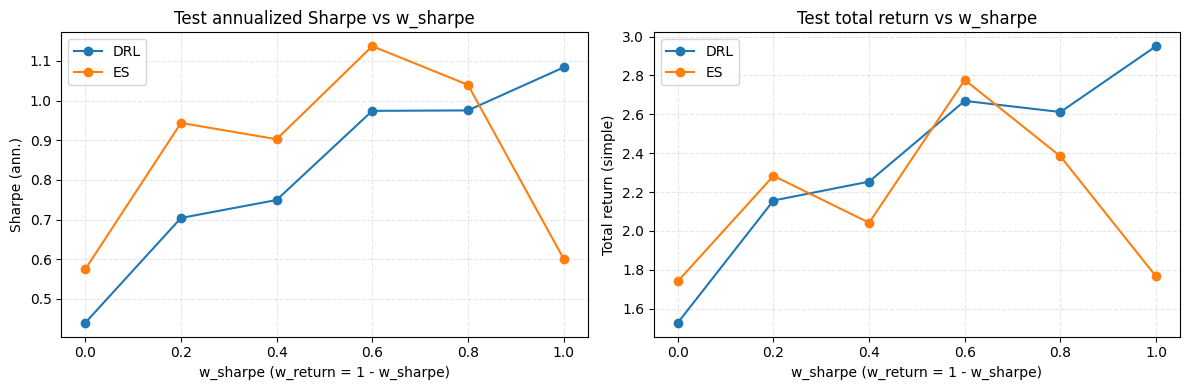

In [22]:
if len(summary_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    for algo, grp in summary_df.groupby("algo"):
        grp = grp.sort_values("w_sharpe", ascending=False)
        axes[0].plot(grp["w_sharpe"], grp["test_sharpe_ann"], marker="o", label=algo)
        axes[1].plot(grp["w_sharpe"], np.exp(grp["test_total_log_return"]), marker="o", label=algo)

    axes[0].set_title("Test annualized Sharpe vs w_sharpe")
    axes[0].set_xlabel("w_sharpe (w_return = 1 - w_sharpe)")
    axes[0].set_ylabel("Sharpe (ann.)")
    axes[0].grid(True, linestyle="--", alpha=0.3)

    axes[1].set_title("Test total return vs w_sharpe")
    axes[1].set_xlabel("w_sharpe (w_return = 1 - w_sharpe)")
    axes[1].set_ylabel("Total return (simple)")
    axes[1].grid(True, linestyle="--", alpha=0.3)

    for ax in axes:
        ax.legend()

    plt.tight_layout()
    plt.show()


The figure shows how out-of-sample performance changes as we shift the objective from pure return low w_sharpe toward pure Sharpe high w_sharpe. DRL behaves relatively smoothly: increasing w_sharpe leads to a steady rise in test Sharpe and, in our runs, also improves test return, suggesting that adding a risk-adjusted term discourages overly volatile/high-turnover behavior and helps generalization. ES is highly competitive: it achieves higher test Sharpe than DRL for most mixed objectives and reaches its best overall trade-off around w_sharpe = 0.6, where both Sharpe and return are strong. However, ES is more sensitive to the objective choice: at the pure-Sharpe setting w_sharpe=1 performance drops sharply in both Sharpe and return, indicating reduced robustness and likely a train–test mismatch when optimizing the ratio-based Sharpe objective. Overall, ES can match or outperform the more traditional DRL approach on this problem under mixed objectives, while DRL appears more stable as the objective weight changes.


## 10) Compare average test allocations

This summarizes the *average* portfolio weights over the test period for each run.


In [12]:
weight_rows = []
for (algo, w_sharpe, w_return), run in runs.items():
    w_test = np.array(run["weights_test"])
    avg_w = w_test.mean(axis=0)
    row = {"algo": algo, "w_sharpe": w_sharpe, "w_return": w_return}
    for name, v in zip(asset_labels_full, avg_w):
        row[name] = float(v)
    weight_rows.append(row)

avg_alloc_df = (
    pd.DataFrame(weight_rows)
    .sort_values(["algo", "w_sharpe"], ascending=[True, False])
)
avg_alloc_df


algo  w_sharpe  w_return  US_REITs_VNQ  US_SmallCap_IWM  Gold_GLD  \
0   DRL       1.0       0.0      0.475323         0.068518  0.207732   
2   DRL       0.8       0.2      0.503209         0.065989  0.178513   
4   DRL       0.6       0.4      0.523833         0.087158  0.222612   
6   DRL       0.4       0.6      0.586212         0.108593  0.191693   
8   DRL       0.2       0.8      0.595480         0.120232  0.197189   
10  DRL       0.0       1.0      0.614927         0.079704  0.155954   
1    ES       1.0       0.0      0.197759         0.035514  0.150496   
3    ES       0.8       0.2      0.256209         0.044108  0.315006   
5    ES       0.6       0.4      0.267950         0.033431  0.256169   
7    ES       0.4       0.6      0.288520         0.065947  0.193264   
9    ES       0.2       0.8      0.372779         0.107750  0.229007   
11   ES       0.0       1.0      0.554830         0.083201  0.170017   

    US_LargeCap_SPY  Europe_VGK   DevExUS_EFA  US_Bonds_AGG  Emerging_EEM  \
0          0.122996    0.006629  6.816390e-03      0.011011  9.974210e-02   
2          0.110464    0.006880  9.494305e-03      0.019203  1.044173e-01   
4          0.086653    0.006511  1.380650e-02      0.022052  3.508859e-02   
6          0.070986    0.004147  1.433040e-02      0.012394  9.396615e-03   
8          0.041748    0.006380  1.231768e-02      0.013834  7.731635e-03   
10         0.038151    0.017638  2.631174e-02      0.023480  3.186369e-02   
1          0.240157    0.042055  8.833322e-08      0.334016  1.453027e-09   
3          0.168308    0.007611  1.485504e-03      0.201033  4.020533e-03   
5          0.270388    0.007419  1.989949e-03      0.159288  2.870447e-03   
7          0.244494    0.018608  7.074528e-03      0.165958  1.428955e-02   
9          0.130360    0.009269  8.021844e-03      0.134134  5.759615e-03   
11         0.043491    0.021327  2.859181e-02      0.045022  3.889152e-02   

        Cash  
0   0.001234  
2   0.001831  
4   0.002287  
6   0.002246  
8   0.005089  
10  0.011970  
1   0.000002  
3   0.002219  
5   0.000493  
7   0.001845  
9   0.002922  
11  0.014626

This table reports average portfolio allocations over the test period, so it reflects typical exposure rather than short-term rebalancing dynamics. For DRL, the allocations are highly stable across objective weights and consistently dominated by US REITs (VNQ), which account for roughly half or more of the portfolio in all runs. The remaining weight is mainly split between Gold (GLD) and US equities (SPY and IWM), while bonds, international equities, emerging markets, and cash remain close to zero. Changes in w_sharpe only mildly affect this structure, indicating that DRL converges to a similar portfolio composition regardless of the precise objective weighting.

In contrast, ES shows much stronger sensitivity to the objective. Under Sharpe-heavy objectives, ES allocates a substantial fraction to US bonds (AGG) alongside diversified exposure to SPY, VNQ, and GLD, reflecting explicit risk control. As the objective shifts toward return, the bond allocation steadily decreases and the portfolio becomes more concentrated in VNQ and, to a lesser extent, IWM and GLD. At the pure return objective, ES ends up with a highly concentrated VNQ-dominated allocation similar in spirit to DRL, but reached through a gradual transition rather than a fixed structure. Overall, these allocation patterns are consistent with the performance results: ES adapts its risk profile more directly in response to the objective, while DRL exhibits greater structural stability but less sensitivity to changes in the optimization criterion.

## 11) Inspect a specific run (loss / performance / allocations)


## Notes for each weight 
- DRL W_SHARPE = 1, W_RETURN = 0 The train and test loss seem not to be too tact as we see only small decline for the test loss in the first iterations and then even stedy rise. The comparison to SP500 over the train period shows a significant overperformance as our policy learned to generate 40 times the initial wealth in the mean time sp 500 only doubled which we can see as a overfitting which alligns with the loss, though our performance on the test sample is still great as we beat the sp500 as we triple our wealth in comparison to 2.25 gain of sp500 from 2020 to 2025. Solution which uses solely sharpe ratio for optimization can therefore be seen as pretty successfull as the policy optimized by reinforcement learning was sucessfull. 
- ES W_SHARPE = 1, W_RETURN = 0 The Train and val loss again do not align perfectly though the validation loss goes down at the end and ES found better solution in terms of sharpe for the data in comparison  to the DRl algorithm though it cost it the performance in returns as it got beaten out by the sp500.Though as the objective was having better sharpe it effectively succeed.

- DRL W_SHARPE  = 0.8, W_RETURN = 0.2 same fenomena as in 1,0 weight with the objective function and massive overfit. We still beat out the sp500 though not so severly as when only optimizing for sharpe
-  ES W_SHARPE  = 0.8, W_RETURN = 0.2 we overfit masively with es as well as we 20x our initial wealth and we slightly beat the sp500 our portfolio mainly uses gold and bonds in the test solution

- DRL W_SHARPE  = 0.6, W_RETURN = 0.4 roughly the same solution is find as before again overfit which in turn beats the sp500 again. Mainly trading us real estate etf and gold
-  ES W_SHARPE  = 0.6, W_RETURN = 0.4 we again overfit with es as well as we 20x our initial wealth and we beat the sp500 now more as we triple our wealth. Now the porfolio switches more towards sp500 and gold heavy for the test set. Not relying so much on the bonds as with the higher sharpe weights

- DRL W_SHARPE  = 0.4, W_RETURN = 0.6 the loss function smooths out for the higher return weight we platoe with the test loss now being completely even with the sp500 on the test sample. Still masively investing in the real estate market both on test and train with some volume of gold, then small us firms and finaly some sp500 in our portfolio
- ES W_SHARPE  = 0.4, W_RETURN = 0.6 the loss function for es now looks very similar to the one in DRL with test sample platoing after 25 iterations and train loss going down quickly. The overfit losses out against the sp500 slightly. The end solution uses a lot of bonds, real estate, gold, sp500  being more diverse then drl though less efficient.

- DRL W_SHARPE  = 0.2, W_RETURN =  0.8 The loss function for both train and test still seems to go down slowly now more than with the more sharp oriented portfolios. We lose on test data slightly when comparing to sp500 it seems the focus on returns limits our solution to not be so well prepared for the test data. We allocate a lot of real estate, gold and lastly small us companies
- ES W_SHARPE  = 0.2, W_RETURN =  0.8 the loss function for es again looks very similar to the one in DRL with both the test and train still looking like they might not have converged. The solution matches the gains on test data to the ones of the sp500. The end solution uses a lot of gold, real estate, bonds, sp500  being again more diverse then drl though less efficient.

- DRL W_SHARPE  = 0, W_RETURN =1 The loss function for both train and test seems to go down very slowly when only optimizing returns. We beat the marked on train as we 14x our wealth though we are lost on test data as we only 1.5 our wealth the sharpe not in our objective function throws us off. The portfolio buys mostly real estate and bit of gold

- ES W_SHARPE  = 0, W_RETURN = 1 similar story for es as for DRL they perform almost the same even the final portfolio in time looks fairly comparable.

DRL | w_sharpe=0.20, w_return=0.80
Train metrics: {'total_log_return': 3.2958199977874756, 'total_simple_return': 25.99954456198618, 'mean_daily': 0.0010215193033218384, 'std_daily': 0.014503341168165207, 'mean_ann': 0.25742286443710327, 'sharpe_ann': 1.1180951564119468}
Test metrics:  {'total_log_return': 0.7685088515281677, 'total_simple_return': 1.1565481215888211, 'mean_daily': 0.0005897548981010914, 'std_daily': 0.013296259567141533, 'mean_ann': 0.14861823432147503, 'sharpe_ann': 0.7041129332893722}


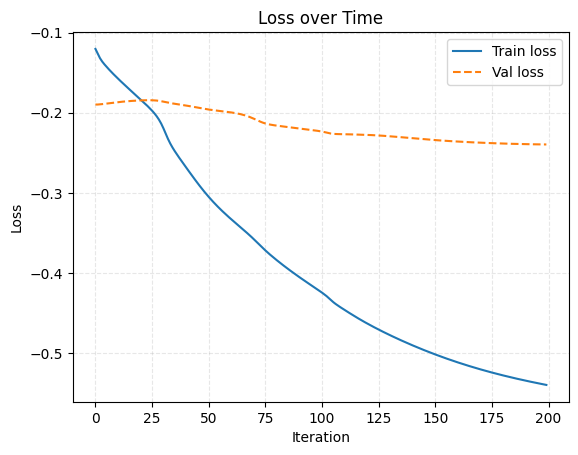

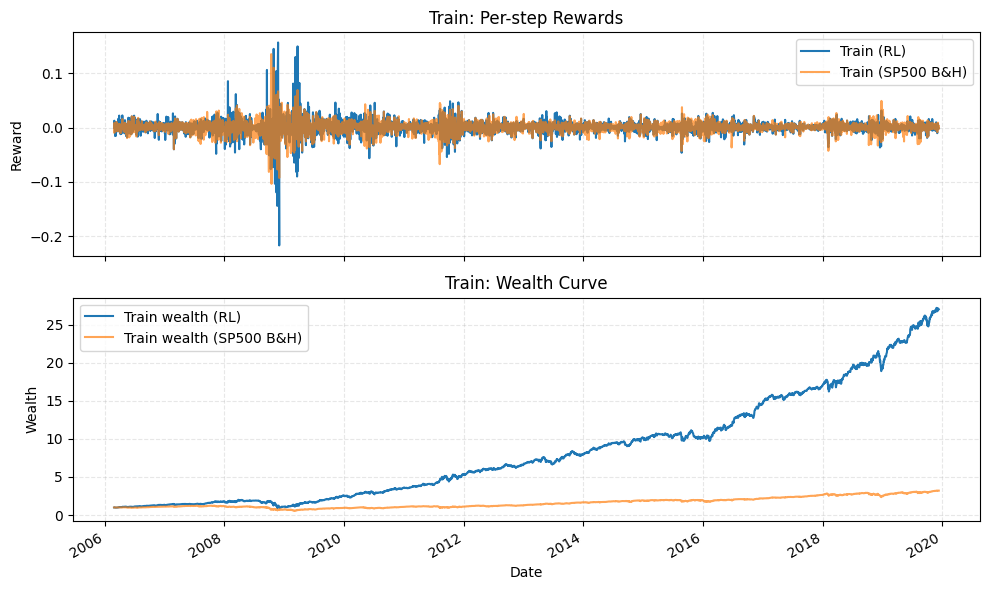

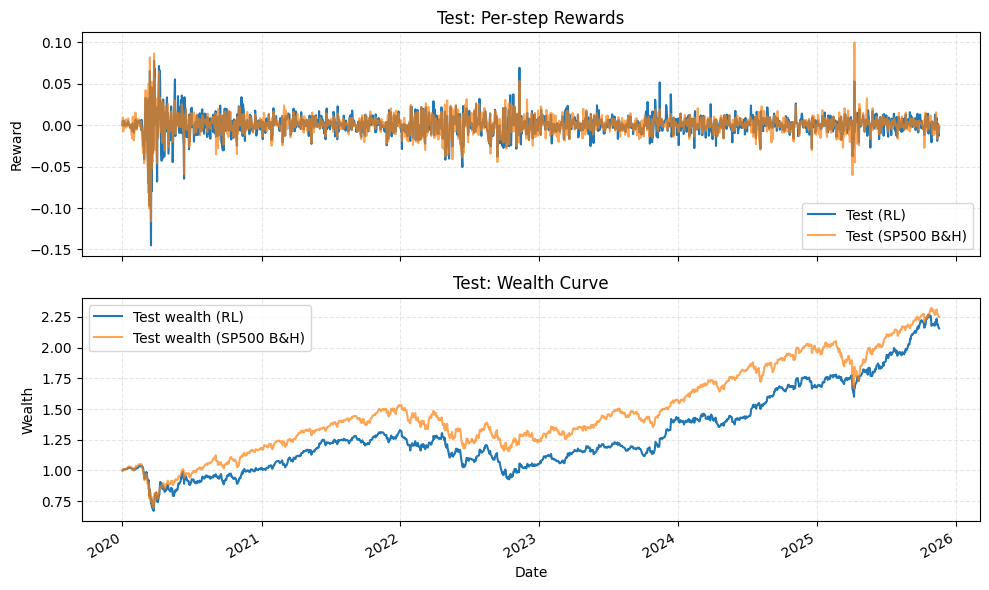

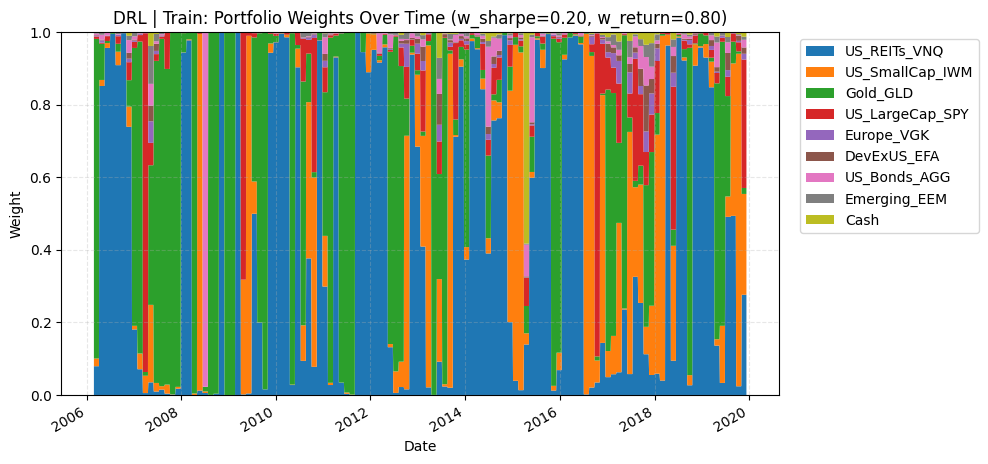

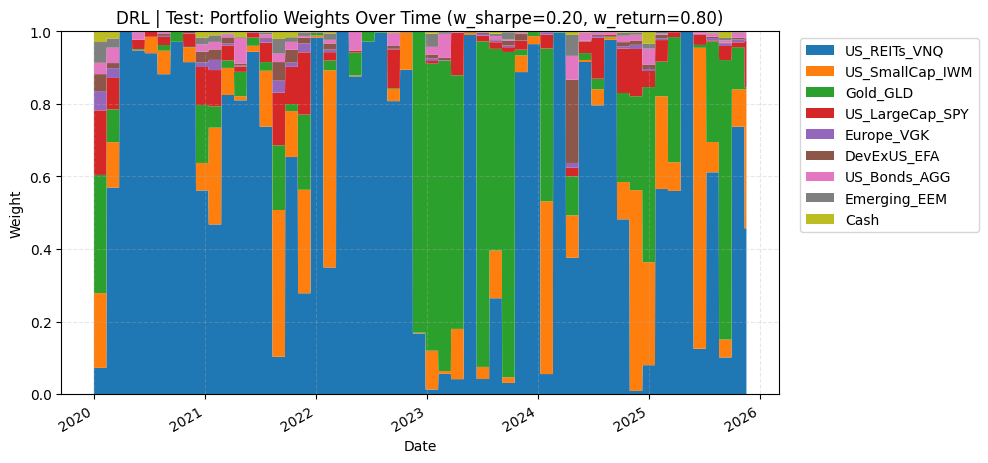

ES | w_sharpe=0.20, w_return=0.80
Train metrics: {'total_log_return': 3.556551218032837, 'total_simple_return': 34.042135821931815, 'mean_daily': 0.0010350680677220225, 'std_daily': 0.009603350423276424, 'mean_ann': 0.2608371530659497, 'sharpe_ann': 1.7109856853348286}
Test metrics:  {'total_log_return': 0.8257721662521362, 'total_simple_return': 1.2836434370979353, 'mean_daily': 0.0005870357272215188, 'std_daily': 0.009874711744487286, 'mean_ann': 0.14793300325982273, 'sharpe_ann': 0.9437138942660359}


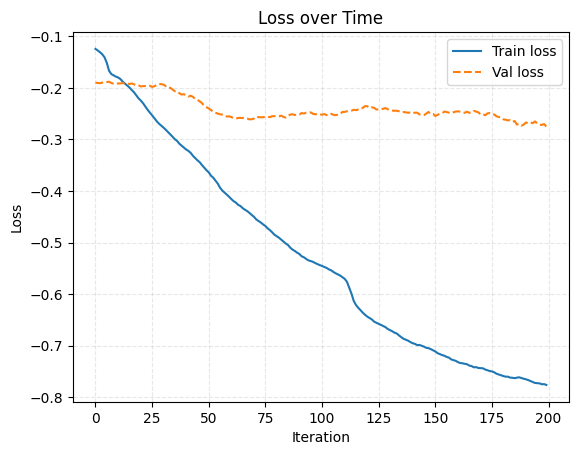

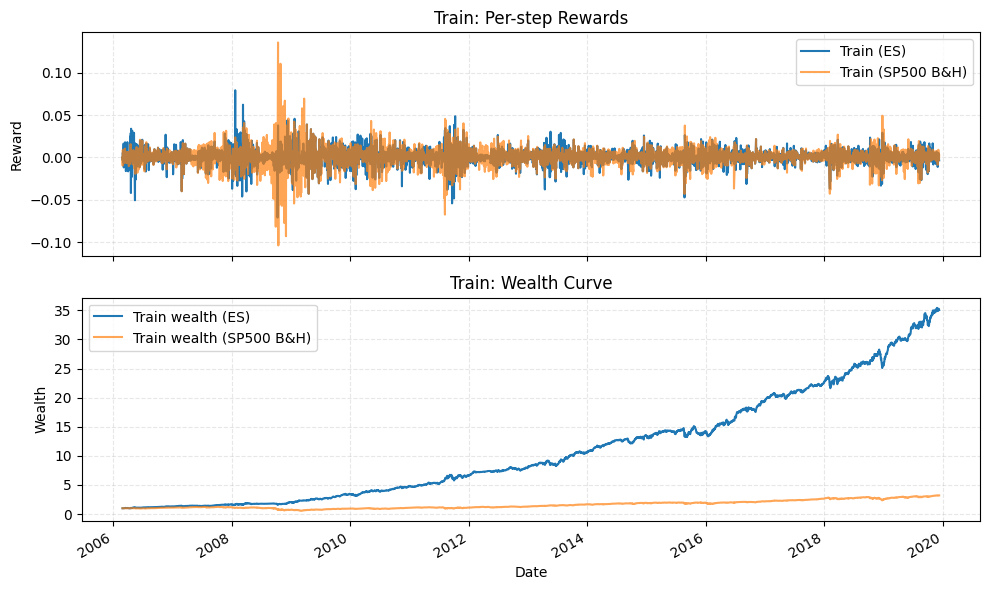

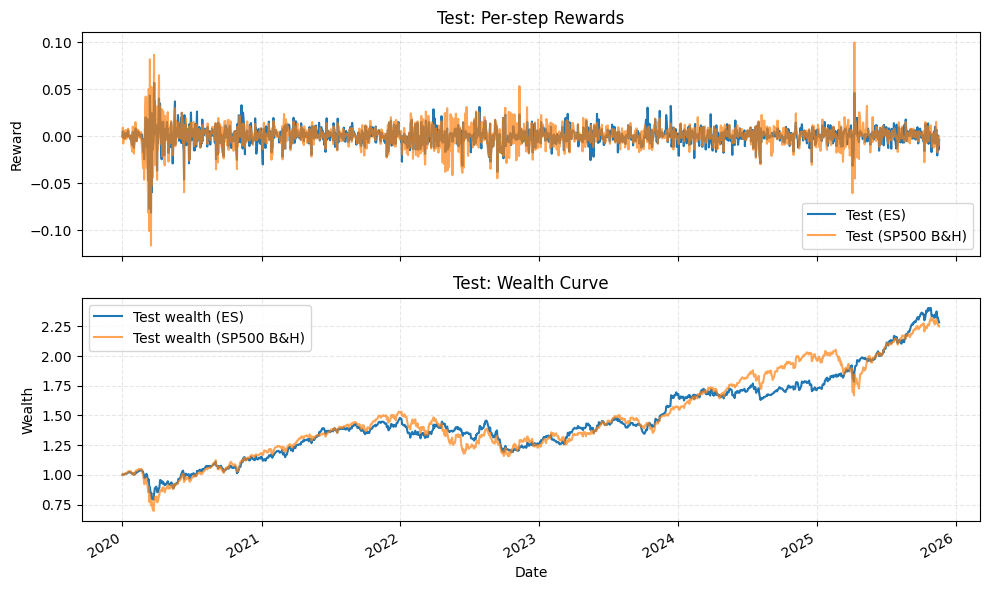

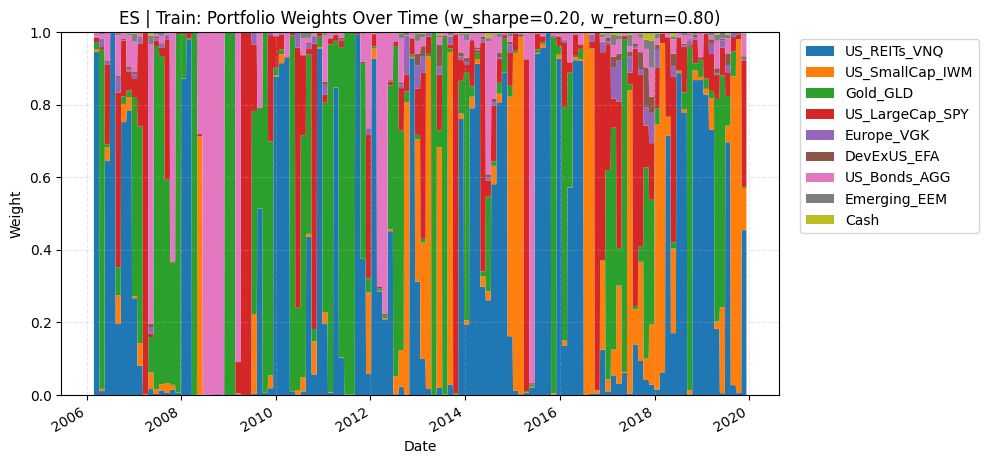

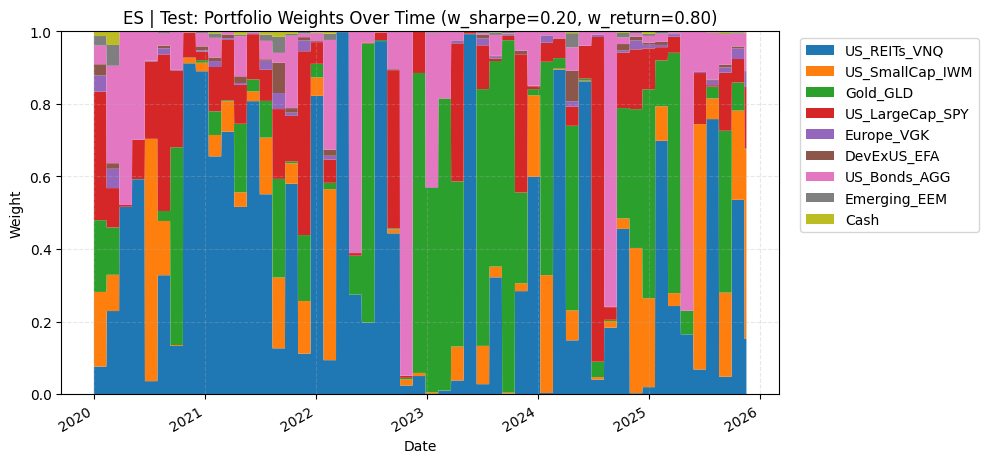

In [27]:
# Pick a weight pair to inspect
W_SHARPE, W_RETURN = 0.2, 0.8

if ("DRL", W_SHARPE, W_RETURN) in runs:
    plot_run(runs[("DRL", W_SHARPE, W_RETURN)])

if ("ES", W_SHARPE, W_RETURN) in runs:
    plot_run(runs[("ES", W_SHARPE, W_RETURN)])
